In [1]:
# Notebook to separate and analyze cells based on tuning 

In [13]:
# import and load modules
%reload_ext autoreload
%autoreload 2
import pprint
import operator
import numpy as np; import pandas as pd; import math as math; import copy; import statistics
from scipy.ndimage import gaussian_filter as gaussian_filter; import scipy.stats as stats
import statsmodels.api as sm; lowess = sm.nonparametric.lowess; from skimage import transform
from scipy.optimize import curve_fit
from scipy.special import i0 

#from loess.loess_1d import loess_1d;
import seaborn as sns
from seaborn import violinplot
from seaborn import load_dataset
from seaborn import kdeplot

#mworks importsc
#from mworksbehavior import mwkfiles; from mworksbehavior.imaging import intrinsic as ii; import mworksbehavior as mwb; import mworksbehavior.mwk_io

import matplotlib as mpl; import matplotlib.pyplot as plt; import matplotlib.gridspec as gridspec; from matplotlib import cm; from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable #from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle; from matplotlib.patches import Rectangle

import os, sys; from glob import glob; from pathlib import Path; import pickle
import tifffile as tfl; from datetime import datetime

sys.path.append(Path('src').resolve().as_posix()); 
import quietcell_select_fxns_all as qcsf
import compareQuiet as cQ

#local files and shorthand notations for assigning common functions to variable names
r_ = np.r_; a_ = np.asarray

## Loading in Trial Data

In [5]:
data_dir = '\\Users\\Connor\\data-local\\250405'
pre_data = []
post_data = []
pre_ctrl = []
post_ctrl = []

animals = os.listdir(data_dir)
for animal in animals: 
    animal_dir = data_dir+'\\'+animal
    inds = np.load(animal_dir+'\\stim_iC_manip.npy')
    inds_ctrl = np.load(animal_dir+'\\ctrl_iC.npy')
    # Store arrays as elements in a list, filtered by appropriate indicies
    pre_data.append(np.load(animal_dir+'\\dfof_cellTrials_pre.npy')[inds,:])
    pre_ctrl.append(np.load(animal_dir+'\\dfof_cellTrials_pre.npy')[inds_ctrl,:])
    post_data.append(np.load(animal_dir+'\\dfof_cellTrials_post.npy')[inds,:])
    post_ctrl.append(np.load(animal_dir+'\\dfof_cellTrials_post.npy')[inds_ctrl,:])

# Stack arrays in list to create one array of all animal's cells 
pre_data = np.vstack(pre_data)
pre_ctrl = np.vstack(pre_ctrl)
post_data = np.vstack(post_data)
post_ctrl = np.vstack(post_ctrl)

## Calculating Mean and Error

In [6]:
# Trained cells mean
visResp_behavStim_pre = pre_data.mean(axis=2)
visResp_behavStim_post = post_data.mean(axis=2)
# Trained cells error 
pre_err = stats.sem(pre_data,axis=2) 
post_err = stats.sem(post_data,axis=2)
# Control cells mean 
visResp_notStim_pre = pre_ctrl.mean(axis=2)
visResp_notStim_post = post_ctrl.mean(axis=2)
# A filter for lower quality control data (i.e. filtering all cells identified by suite2p), 
#can make 7% could also be any orientation in pre or post
i_notStimResponsive = np.where(visResp_notStim_pre[:,3] > 2.5)[0] 
stat, p_post = stats.mannwhitneyu(visResp_behavStim_post, visResp_notStim_post)

## Individual Cell Tuning Plots

In [7]:
# A filter for lower quality control data (i.e. filtering all cells identified by suite2p), 
#can make 7% could also be any orientation in pre or post
i_notStimResponsive = np.where(visResp_notStim_pre[:,3] > 2.5)[0] 
stat, p_post = stats.mannwhitneyu(visResp_behavStim_post, visResp_notStim_post)
# Calculating the change for control & trained cells 
dfoF_V_change_ctrl = visResp_notStim_post[i_notStimResponsive,:] - visResp_notStim_pre[i_notStimResponsive,:]
dfoF_V_change_bhStim = visResp_behavStim_post - visResp_behavStim_pre

In [18]:
# Appending the 0 deg column to the end for the +90 condition 
add_col = np.expand_dims(visResp_behavStim_pre[:,0],axis=1)
bhStim_pre = np.append(visResp_behavStim_pre,add_col,axis=1)

add_col = np.expand_dims(visResp_behavStim_post[:,0],axis=1)
bhStim_post = np.append(visResp_behavStim_post,add_col,axis=1)

# Checking if the appropriate column was appended:
print(f"Do the first and last columns of the visual response match?: {all((bhStim_post[:,0] == bhStim_post[:,-1]))}")

Do the first and last columns of the visual response match?: True


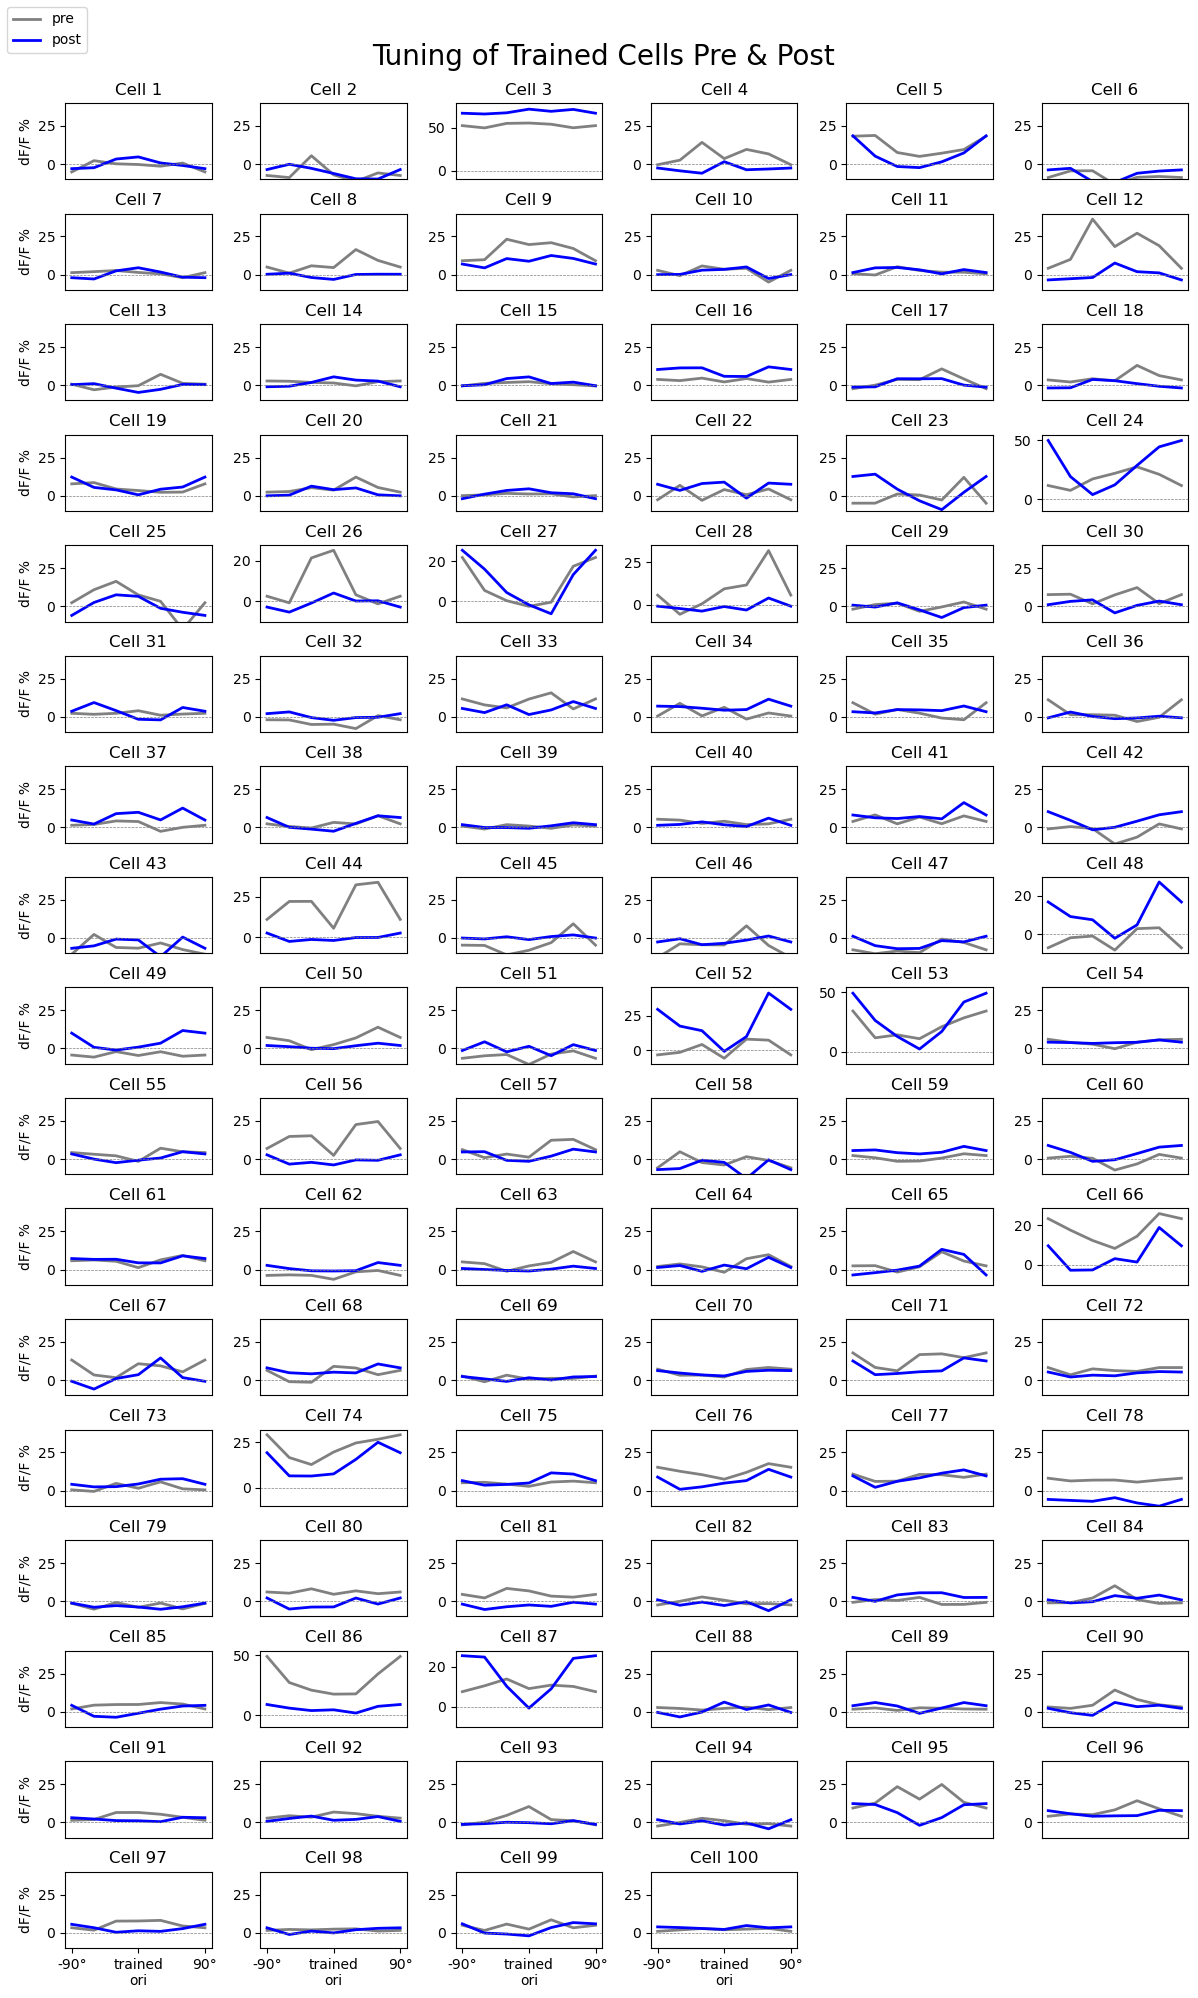

In [19]:
# Plotting all the pre- and post-tuning of each cell

# Set the dimensions of the subplot grid
cols = 6
rows = int(np.ceil(len(dfoF_V_change_bhStim)/cols))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 20))
xs = [0,np.pi*0.167,np.pi*0.333,np.pi*0.5,np.pi*0.667,np.pi*0.833,np.pi]

pre_color = 'gray'
post_color = 'blue'


axes = axes.flatten()

# Iterate through each subplot
for i in range(dfoF_V_change_bhStim.shape[0]):
        
    ax = axes[i]
    ax.plot(xs,bhStim_pre[i,:],lw=2,color=pre_color,label='pre')
    ax.plot(xs,bhStim_post[i,:],lw=2,color=post_color,label='post')
    ax.axhline(0, color='gray',lw=0.5,linestyle='--')

    
    # # To account for a cell with higher responses & to add label to first plot  
    # if i == 21:
    #     ax.set_ylim([-100, 100])
    # elif i == 0:
    #     ax.set_ylabel("dF/F %")
    # else:
    #     ax.set_ylim([-10, 40])   
        
    ax.set_title(f'Cell {i + 1}', fontsize=12)
    
    
    # Code to set the ylims based on values with a minimum of 25% 
    if any(bhStim_pre[i,:] > 25) or any(bhStim_post[i,:] > 25):
        y_max = np.max(np.concatenate((bhStim_pre[i,:],bhStim_post[i,:])))*1.1 # Making max ylim 1.1 
        ax.set_ylim([-10,y_max])
        
    else: 
        ax.set_ylim([-10, 40])   
        
    if i == 0:
        fig.legend(loc='upper left')
        
    # Setting only the first column to have y labels 
    if np.remainder(i,cols) == 0:
        ax.set_ylabel("dF/F %")
    
    # Setting only the last row to have x labels 
    if (rows*cols) - i - 1< cols:
        ax.set_xticks(
            ticks=[0, np.pi*0.5, np.pi],
            labels=["-90\u00b0", "trained\nori", "90\u00b0"])  
    else: 
        ax.set_xticks(
            ticks=[],
            labels=[])

# Removing axes greater than the number of cells 
for ind in range(rows*cols - dfoF_V_change_bhStim.shape[0]):
    ax = axes[dfoF_V_change_bhStim.shape[0] + ind]
    ax.axis('off') 
        
plt.tight_layout()
plt.rcParams.update({'font.size': 12}) 
fig.suptitle("Tuning of Trained Cells Pre & Post", fontsize = 20)
fig.subplots_adjust(top=0.95)

plt.show()

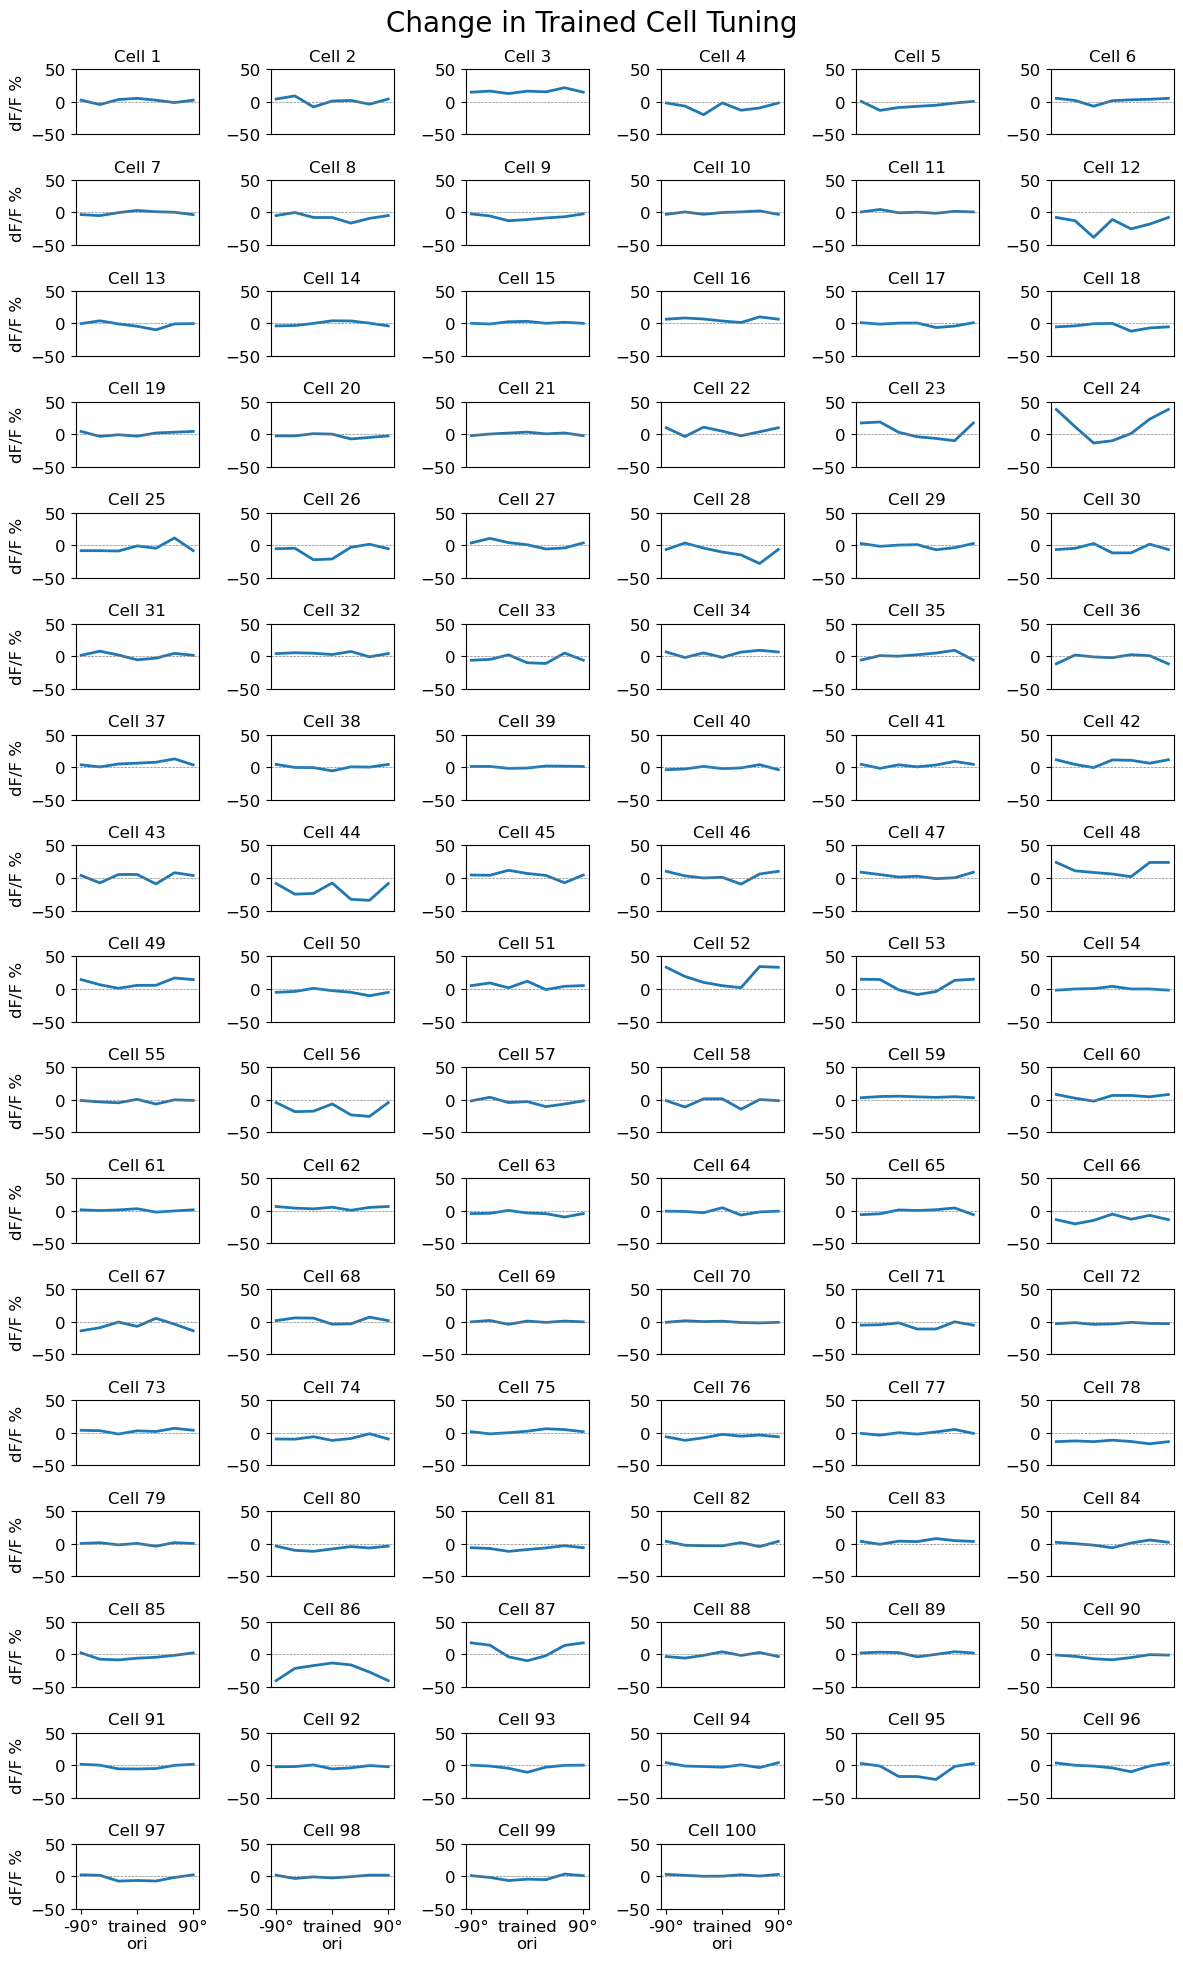

In [7]:
# Plotting the change in tuning for each cell 

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 20))
axes = axes.flatten() # to make iterable

xs = [0,np.pi*0.167,np.pi*0.333,np.pi*0.5,np.pi*0.667,np.pi*0.833,np.pi]

add_col = np.expand_dims(dfoF_V_change_bhStim[:,0],axis=1)
bhStim_total = np.append(dfoF_V_change_bhStim,add_col,axis=1)

# Iterate through each subplot
for i in range(dfoF_V_change_bhStim.shape[0]):
    ax = axes[i]
    ax.plot(xs,bhStim_total[i,:],lw=2)
    ax.axhline(0, color='gray',lw=0.5,linestyle='--')
    #ax.set_ylim([-40, 40])
    ax.set_title(f'Cell {i + 1}', fontsize=12)
    ax.set_xticks(
        ticks=[0, np.pi*0.5, np.pi],
        labels=["-90\u00b0", "trained\nori", "90\u00b0"])
    
    if i == 0:
        ax.set_ylabel('\u0394d F/F%')
        
        
    # Code to set the ylims based on values with a minimum of 25% 
    if any(bhStim_total[i,:] > 50):
        limit = bhStim_total[i,:]*1.1 # Making max ylim 1.1 
        y_max_ind = np.argmax(abs(limit)) 
        
        if limit[y_max_ind] > 0: 
            ax.set_ylim([-50,limit[y_max_ind]])
        else:
            ax.set_ylim([limit[y_max_ind],50])

    else: 
        ax.set_ylim([-50, 50])   
        
    # Setting only the first column to have y labels 
    if np.remainder(i,cols) == 0:
        ax.set_ylabel("dF/F %")
    
    # Setting only the last row to have x labels 
    if (rows*cols) - i - 1< cols:
        ax.set_xticks(
            ticks=[0, np.pi*0.5, np.pi],
            labels=["-90\u00b0", "trained\nori", "90\u00b0"])  
    else: 
        ax.set_xticks(
            ticks=[],
            labels=[])

# Removing axes greater than the number of cells 
for ind in range(rows*cols - dfoF_V_change_bhStim.shape[0]):
    ax = axes[dfoF_V_change_bhStim.shape[0] + ind]
    ax.axis('off') 

plt.tight_layout()
plt.rcParams.update({'font.size': 10}) 
fig.suptitle("Change in Trained Cell Tuning", fontsize = 20)
fig.subplots_adjust(top=0.95)

plt.show()

In [8]:
# Cell that calculates quiet cells in trained and control populations 
quiet_cell_threshold = 10 # Percent
group_names = ["Trained", "Control"]
qc_store_pre = []
qc_store_post = []
stay_qc_store = []
lost_qc_store = []

ctrl_vis_pre = visResp_notStim_pre[i_notStimResponsive,:]
ctrl_vis_post = visResp_notStim_post[i_notStimResponsive,:]

# Trained and control data for pre and post 
pre = [visResp_behavStim_pre, 
            ctrl_vis_pre]

post = [visResp_behavStim_post,
             ctrl_vis_post]

trained = 0 
control = 1 

# Looping through trained and control data trained is 0 control is 1 
for group in range(2): 
    
    pre_loop = pre[group] 
    post_loop = post[group] 
    
    # Calculating the number of quiet cells in our data
    # loop through cells (row) and find which rows have all entries less that threshold (some dF/F percentage) 
    pre_quiet_cells = [np.all(np.abs(pre_loop[row,:]) < quiet_cell_threshold) for row in range(pre_loop.shape[0])] 
    post_quiet_cells = [np.all(np.abs(post_loop[row,:]) < quiet_cell_threshold) for row in range(post_loop.shape[0])]
    stay_quiet_cells = np.logical_and(pre_quiet_cells,post_quiet_cells)
    # Condition for is initially quiet and not a stay quiet cell, meaning it gains a response
    lost_quiet_cells = np.logical_and(pre_quiet_cells,~stay_quiet_cells)
    
    # Print Block for Info
    print("%s Cells" %group_names[group])
    print("Number of starting quiet cells: %i" % len([i for i, x in enumerate(pre_quiet_cells) if x])) # If x (entry) is True, store index i then count list
    print("Number of ending quiet cells: %i" % len([i for i, x in enumerate(post_quiet_cells) if x]))
    print("Cells that remained quiet: %i" % len([i for i, x in enumerate(stay_quiet_cells) if x]))
    print("Cells that gained tuning: %i" % len([i for i, x in enumerate(lost_quiet_cells) if x]))
    percent_stay_quiet = len([i for i, x in enumerate(stay_quiet_cells) if x])/pre_loop.shape[0]*100
    percent_lost_quiet = len([i for i, x in enumerate(lost_quiet_cells) if x])/pre_loop.shape[0]*100
    print("Percent of cells that remained quiet: %i%%" % int(percent_stay_quiet))
    print("Percent of cells that gained a tuning: %i%%\n" % int(percent_lost_quiet))
    
    # Append arrays for later use, remember index [0] is trained cells index [1] is post
    qc_store_pre.append(pre_quiet_cells)
    qc_store_post.append(post_quiet_cells)
    stay_qc_store.append(stay_quiet_cells)
    lost_qc_store.append(lost_quiet_cells)
    
# Pulling out stay quiet cells for data analysis in case
trained_stay_quiet_cells = stay_qc_store[trained]
ctrl_stay_quiet_cells = stay_qc_store[control] 

Trained Cells
Number of starting quiet cells: 54
Number of ending quiet cells: 69
Cells that remained quiet: 42
Cells that gained tuning: 12
Percent of cells that remained quiet: 42%
Percent of cells that gained a tuning: 12%

Control Cells
Number of starting quiet cells: 525
Number of ending quiet cells: 557
Cells that remained quiet: 450
Cells that gained tuning: 75
Percent of cells that remained quiet: 59%
Percent of cells that gained a tuning: 9%



In [47]:
# pre_avg = []
# pre_ctrl_avg = []
# post_avg = []
# post_ctrl_avg = []

# #Checking plot with average arrays 
# animals = os.listdir(data_dir)
# for animal in animals: 
#     animal_dir = data_dir+'\\'+animal
#     inds = np.load(animal_dir+'\\stim_iC_manip.npy')
#     inds_ctrl = np.load(animal_dir+'\\ctrl_iC.npy')
#     # Store arrays as elements in a list, filtered by appropriate indicies
#     pre_avg.append(np.load(animal_dir+'\\dfof_avgTrial_cell_pre.npy')[inds,:])
#     pre_ctrl_avg.append(np.load(animal_dir+'\\dfof_avgTrial_cell_pre.npy')[inds_ctrl,:])
#     post_avg.append(np.load(animal_dir+'\\dfof_avgTrial_cell_post.npy')[inds,:])
#     post_ctrl_avg.append(np.load(animal_dir+'\\dfof_avgTrial_cell_post.npy')[inds_ctrl,:])

# # Stack arrays in list to create one array of all animal's cells 
# visResp_behavStim_pre = np.vstack(pre_avg)
# visResp_notStim_pre = np.vstack(pre_ctrl_avg)
# visResp_behavStim_post = np.vstack(post_avg)
# visResp_notStim_post = np.vstack(post_ctrl_avg)

# for animal in animals: 
#     # Confirm pre and post data for manip are same shape
#    # print(pre_data.shape==post_data.shape)
#     # Show data shape for each animal 
#     print(animal+' shape is:'+str(visResp_behavStim_pre.shape)) 

i5214 shape is:(100, 6, 140)
i5273 shape is:(100, 6, 140)
i5309 shape is:(100, 6, 140)
i5398 shape is:(100, 6, 140)
i5439 shape is:(100, 6, 140)


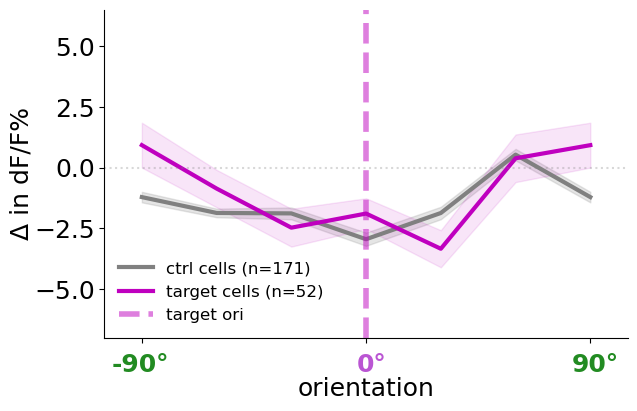

In [43]:
# avg_ctrl = np.nanmean(dfoF_V_change_ctrl, axis=0)
# avg_ctrl = np.concatenate((avg_ctrl, avg_ctrl[:1]))
# avg_bhStim = np.nanmean(dfoF_V_change_bhStim, axis=0)
# avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))

# sem_ctrl = stats.sem(dfoF_V_change_ctrl, axis=(0),nan_policy='omit')
# sem_ctrl = np.concatenate((sem_ctrl, sem_ctrl[:1]))
# sem_bhStim = stats.sem(dfoF_V_change_bhStim, axis=(0),nan_policy='omit')
# sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))

# difs = [avg_ctrl, avg_bhStim]

# fig= plt.figure(figsize=(12,8))
# #fig.text(0.5, 0.435, '*sub selected visually responsive (df/f>7)\nnot stimd cell pop to match mean vis resp of stimd cells', ha='left', va='center', fontsize=10)
# colors = ['grey', 'm']
# font = {'size'   : 18}
# mpl.rc('font', **font)
# #fig.text(0.52, 0.44, 'orientation', ha='center', va='center')
# xs = [0,1,2,3,4,5,6]

# ax1 = fig.add_subplot(221+1)
# ax1.plot(difs[0],color=colors[0],lw=3,label='ctrl cells (n=171)')
# ax1.plot(difs[1],color=colors[1],lw=3,label='target cells (n=52)')
# ax1.fill_between(xs,difs[0]+sem_ctrl,difs[0]-sem_ctrl,color=colors[0],alpha=0.2)
# ax1.fill_between(xs,difs[1]+sem_bhStim,difs[1]-sem_bhStim,color=colors[1],alpha=0.1)
# ax1.set_xlabel('orientation')
# ax1.set_xticks([0,3,6]); ax1.set_xticklabels([' ',' ',' '])
# ax1.text(-0.4,-8.4,'-90°',c='forestgreen',weight='semibold')
# ax1.text(2.88,-8.4,'0°',c='mediumorchid',weight='semibold')
# ax1.text(5.75,-8.4,'90°',c='forestgreen',weight='semibold')
# ax1.set_ylabel('Δ in dF/F%',labelpad= 0)
# ax1.set_ylim([-7,6.5])
# ax1.set_xlim([-0.5,6.5])
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.axhline(c='grey',alpha=0.3,ls=':'); ax1.axvline(x=3,c=colors[1],alpha=0.5, ls='--',lw=4, label='target ori')
# ax1.legend(loc='lower left',fontsize=12,frameon=False)
# plt.subplots_adjust(wspace=None, hspace=None); plt.tight_layout()
# #plt.savefig(file_path_save+'changeplot_wsem.png',bbox_inches='tight',dpi=400)
# #plt.savefig('/Users/friedmanng/Desktop/umd_nih/2024commeetee/changeplot_sup.png',bbox_inches='tight',dpi=400)
# #plt.savefig('/Users/phillipscm/Downloads/241021-figs/changeplot_tuncurve.png',bbox_inches='tight',dpi=400)

## Fitting Curves to Tuning Data

In [9]:
# Removing quiet cells from tuning curve analysis - TRAINED CELLS ONLY see 0 index, 1 is control cells
qc_inds_pre = np.array(qc_store_pre[0]) # changing to numpy to reverse later
qc_inds_post = np.array(qc_store_post[0])
no_qc_vis_pre = visResp_behavStim_pre[~qc_inds_pre]
no_qc_vis_post = visResp_behavStim_pre[~qc_inds_post]

In [166]:
# Repeating orientations to pair angles with bootstrapped data 
ori_holder = []
ori_temp = orientations.tolist()

for i in range(30): 
    ori_holder.append(ori_temp)

ori_holder = np.array(ori_holder)
ori_holder = ori_holder.flatten()


In [160]:
# Inputs: trial data, orientation placeholder, and average data (just for shape)
# Outputs: average tuning curves for cells in average data using sample w replacement
def sample_w_replacement(input_trial_data,ori_holder,desired_output_shape):

    # Creating code to resample from the data to length of 180
    resampled_dfof = np.empty_like(ori_holder).astype(float)
    resampled_angles = np.empty_like(ori_holder)
    averages = np.empty(desired_output_shape)

    # Constant
    orientations = np.array([0, 30, 60, 90, 130, 150])
    
    # Generate a random integer in the range of the samples (180), need to loop across cells 
    for i in range(desired_output_shape[0]): 
    
        # Now sample across 180, 180 times (rand so automatically with replacement)
        # and then calculate averages for each orientation to pass into the curve-fitting
        for ind in range(ori_holder.shape[0]):
            
            rand_ind = np.random.randint(ori_holder.shape[0])
    
            # Unravel data to have length 180 (30 trials with 6 orientations), this is dfof data
            # then pair y-value with appropriate x 
            ravel_data = input_trial_data[i].ravel()
            resampled_dfof[ind] = ravel_data[rand_ind]
            resampled_angles[ind] = ori_holder[rand_ind]
    
        # Now pair y-values based on x for average
        ori_bool = [resampled_angles == ori for ori in orientations]
        binned_y = [resampled_dfof[ori] for ori in ori_bool]
            
        # Checking the number of values for each orientation, DO LATER 
    
        # Averaging each y-value for fitting and store
        averages[i] = [np.mean(vals) for vals in binned_y]

    return averages 

In [148]:
# Allocating variables for tuning curve fitting
points_in_fit = 300
# y-values of fit 
fit_response = np.ndarray((2,no_qc_vis_pre.shape[0],points_in_fit)) # first dimension is 2 to store pre and post fits
# kappa is a width parameter of the von mises distribution
kappa_fit = np.ndarray((2,no_qc_vis_pre.shape[0]))
# x-value for the fit 
#theta_fit = np.linspace(0, np.pi*5/6, 300)  # 0° to 180° in radians
theta_fit = np.linspace(0, np.pi*5/6, 300)  # 0° to 180° in radians
# Alt. width parameter 
fwhm_vm = np.ndarray((2,no_qc_vis_pre.shape[0]))
orientations = np.array([0, 30, 60, 90, 130, 150])

In [183]:
# Allocating variables for tuning curve fitting
points_in_fit = 300

bootstrapping_n = 1000

# y-values of fit 
fit_response = np.ndarray((bootstrapping_n,2,visResp_behavStim_pre.shape[0],points_in_fit)) # first dimension is 2 to store pre and post fits
# kappa is a width parameter of the von mises distribution
kappa_fit = np.ndarray((bootstrapping_n,2,visResp_behavStim_pre.shape[0]))
# x-value for the fit 
#theta_fit = np.linspace(0, np.pi*5/6, 300)  # 0° to 180° in radians
theta_fit = np.linspace(0, np.pi*5/6, 300)  # 0° to 180° in radians
# Alt. width parameter 
fwhm_vm = np.ndarray((bootstrapping_n,2,visResp_behavStim_pre.shape[0]))
mu_fit = np.ndarray((bootstrapping_n,2,visResp_behavStim_pre.shape[0]))

orientations = np.array([0, 30, 60, 90, 130, 150])

In [184]:
# Create a loop over the von mises fitting that will run it 1000 times for each cell 

# Uncomment code in fitting we don't need to reduce compute time

# Create a function for running fitting 

In [185]:
# Looping through pre and post to get measures for both
#for i_data, data in enumerate([visResp_behavStim_pre,visResp_behavStim_post]):
for iter_ind in range(bootstrapping_n):

    # Calculate new resampled data each iteration 
    pre_averages = sample_w_replacement(pre_data,ori_holder,visResp_behavStim_pre.shape)
    post_averages = sample_w_replacement(post_data,ori_holder,visResp_behavStim_post.shape)
        
    for i_data, data in enumerate([pre_averages,post_averages]):
        # Iterate through each cell
        for i in range(data.shape[0]):
    
            # Input your data
            responses = data[i,:]
    
            # Normalizing the data 
            responses = responses/np.max(np.abs(responses))
            
            # Convert to radians
            orientations_rad = np.deg2rad(orientations)
    
            # Define von Mises tuning function
            def von_mises_tuning(theta, kappa, mu, B):
                return np.exp(kappa * np.cos(theta - mu)) / (2 * np.pi * i0(kappa)) + B 
    
            # Initial parameter guess: [A, kappa, mu, B]
            #A = np.max(responses) - np.min(responses)
            kappa = 1
            mu = orientations_rad[np.argmax(responses)]
            B = np.min(responses)
            initial_guess = [kappa, mu, B]
    
            try:
                # Step 4: Curve fitting
                params, _ = curve_fit(von_mises_tuning, orientations_rad, responses, p0=initial_guess)
                kappa_fit[iter_ind,i_data,i], mu_fit[iter_ind,i_data,i], beta_fit = params
    
                # Step 5: Plot result
                fit_response[iter_ind,i_data,i,:] = von_mises_tuning(theta_fit, *params)
    
                # Calculate the FWHM for each cell
                peak_val = fit_response[i_data,i,:].max()
                peak_ind = np.abs(fit_response[interi_data,i,:] - peak_val).argmin()
                half_max = peak_val / 2
    
                # Calculating indices where x-values of data-points would be 
                half_ind = np.abs(fit_response[i_data,i,:] - half_max).argmin()
                
                # Assuming (for now) fits are symmetric so can double HWHM
                fwhm_vm[inter_ind,i_data,i] = (theta_fit[peak_ind] - theta_fit[half_ind])*2
    
            except RuntimeError:
                fit_response[iter_ind,i_data,i,:] = [np.nan]*points_in_fit  
                # fwhm_vm[i_data,i] = np.nan

C:\Users\Connor\AppData\Local\Temp\ipykernel_18652\1783275561.py:35: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(von_mises_tuning, orientations_rad, responses, p0=initial_guess)


In [191]:
# Calculating a confidence interval for the boostrapped parameters for each cell
param_ci = []
k_interval = []
confidence_level = 0.95
for cell_ind in range(pre_averages.shape[0]):
    kappa = kappa_fit[:,0,cell_ind]
    mean = np.mean(kappa)
    sem = stats.sem(kappa)
    
    interval = stats.t.interval(confidence_level, len(kappa)-1, loc=mean, scale=sem)

    k_interval.append(interval)

In [192]:
k_interval

[(20.778313548367937, 27.536196871878293),
 (19.966691414529112, 25.675202124824043),
 (0.6876843263419776, 1.2818996667819498),
 (7.351550576020842, 10.088942152583284),
 (8.411619648561116, 12.137567462113493),
 (18.24777389923724, 23.836168791038762),
 (21.65993791154252, 28.516965602992727),
 (33.107146310501506, 40.652270543062),
 (36.90116642341458, 42.584068095175255),
 (16.613804113253845, 21.96128471226486),
 (14.144686359818738, 22.345244955873195),
 (21.26302020776744, 27.275443908203805),
 (31.254626735411414, 38.37765972313543),
 (17.685456823986947, 25.10926207542093),
 (18.00113427852518, 25.89528084166583),
 (65.33780959979964, 75.01036529670705),
 (38.79066451353718, 46.56744510461715),
 (55.74255794465447, 64.75986426766238),
 (16.637521741736748, 22.64196263419536),
 (17.62973511115499, 22.23778902745578),
 (18.229488327765974, 28.186080382967024),
 (25.59800425374261, 33.472963341072386),
 (23.371967383368084, 31.170546237331333),
 (3.0806395830016484, 6.68692111178

### Stats for von mises

In [50]:
# Converting to degrees for readability
fwhm_vm = np.abs(np.rad2deg(fwhm_vm)) 

# Calculating indices where x-values of data-points would be 
indices = np.array([np.abs(np.rad2deg(theta_fit) - ori).argmin() for ori in orientations])

# Variance Accounted For (VAF) 
pre = 0 # accessing pre data in fit, needed to gather FWHM pre post in above loop
# vaf = [(1 - np.var(no_qc_vis_pre[cell,:] - fit_response[pre,cell,indices])/np.var(no_qc_vis_pre[cell,:]))*100 for cell in range(no_qc_vis_pre.shape[0])]
# normalized data 
norm_data = np.ndarray(no_qc_vis_pre.shape)
for cell in range(no_qc_vis_pre.shape[0]):
    norm_data[cell,:] = no_qc_vis_pre[cell,:]/np.max(np.abs(no_qc_vis_pre[cell,:])) 

vaf = [(1 - np.var(norm_data[cell,:] - fit_response[pre,cell,indices])/np.var(norm_data[cell,:]))*100 for cell in range(no_qc_vis_pre.shape[0])]

len(np.where(np.array(vaf)>80))
# Print metrics of fitting
num_cells_fit = len(np.where(~np.isnan(fwhm_vm[0,:]))[0])
p_cells_fit = num_cells_fit/len(no_qc_vis_pre)*100
count_vaf_threshold = np.where(np.array(vaf)>80)[0].shape[0]

print("Cells fit succesfully: %i" %num_cells_fit)
print("Percent of cells fit: %i%%" %p_cells_fit)
print("Average variance accounted for: %.2f%%" %np.nanmean(vaf)) 
print("Cells above 80%% vaf: %i" %count_vaf_threshold)


Cells fit succesfully: 46
Percent of cells fit: 100%
Average variance accounted for: 60.30%
Cells above 80% vaf: 16


## Fitting a cosine function to our data

In [155]:
# Allocating variables for tuning curve fitting
points_in_fit = 300
# y-values of fit 
fit_response = np.ndarray((2,visResp_behavStim_pre.shape[0],points_in_fit)) # first dimension is 2 to store pre and post fits
# kappa is a width parameter of the von mises distribution
A_fit = np.ndarray((2,visResp_behavStim_pre.shape[0]))
theta_0_fit = np.ndarray((2,visResp_behavStim_pre.shape[0]))

# x-value for the fit 
#theta_fit = np.linspace(0, np.pi*5/6, 300)  # 0° to 180° in radians
theta_fit = np.linspace(0, 2*np.pi, 300)  # 0° to 180° in radians
# Alt. width parameter 
fwhm_vm = np.ndarray((2,visResp_behavStim_pre.shape[0]))
orientations = np.array([0, 30, 60, 90, 130, 150])

In [160]:
# Creating fitting code 
# Looping through pre and post to get measures for both
#for i_data, data in enumerate([visResp_behavStim_pre,visResp_behavStim_post]):
for i_data, data in enumerate([visResp_behavStim_pre,visResp_behavStim_post]):
    # Iterate through each cell
    for i in range(data.shape[0]):

        # Step 1: Input your data
        responses = data[i,:]
        
        # Convert to radians
        orientations_rad = 2*np.deg2rad(orientations)

        # Step 2: Define von Mises tuning function
        def cosine_tuning(theta, theta_0, A):
            #return A * np.exp(kappa * np.cos(theta - mu)) + B
            return A * np.cos(2*(theta-theta_0))

        # Step 3: Initial parameter guess: [A, kappa, mu, B]
        A = np.max(responses) - np.min(responses)
        theta_0 = orientations_rad[np.argmax(responses)]
        initial_guess = [A, theta_0]

        try:
            # Step 4: Curve fitting
            params, _ = curve_fit(cosine_tuning, orientations_rad, responses, p0=initial_guess)
            A_fit, theta_0_fit[i_data,i] = params

            # Step 5: Plot result
            fit_response[i_data,i,:] = cosine_tuning(theta_fit, *params)

            # Calculate the FWHM for each cell
            peak_val = fit_response[i_data,i,:].max()
            peak_ind = np.abs(fit_response[i_data,i,:] - peak_val).argmin()
            half_max = peak_val / 2

            # Calculating indices where x-values of data-points would be 
            half_ind = np.abs(fit_response[i_data,i,:] - half_max).argmin()
            
            # Assuming (for now) fits are symmetric so can double HWHM
            fwhm_vm[i_data,i] = (theta_fit[peak_ind] - theta_fit[half_ind])*2

        except RuntimeError:
            fit_response[i_data,i,:] = [np.nan]*points_in_fit  
            fwhm_vm[i_data,i] = np.nan

In [42]:
# Calculating circular variance instead of curve fitting
cv = np.ndarray((2,no_qc_vis_pre.shape[0]))
def circular_variance(angles_rad, responses):
    """
    Compute the circular variance of a neural tuning curve.

    Parameters:
    - angles_rad: array-like, angles in radians
    - responses: array-like, corresponding firing rates or weights

    Returns:
    - circular variance (float, between 0 and 1)
    """
    # Convert to complex exponentials
    vector_sum = np.sum(responses * np.exp(1j * angles_rad))
    R = np.abs(vector_sum) / np.sum(responses)  # Mean resultant length % if responses are all negative
    circ_var = 1 - R
    return circ_var

# Looping through pre and post to get measures for both
#for i_data, data in enumerate([visResp_behavStim_pre,visResp_behavStim_post]):
for i_data, data in enumerate([no_qc_vis_pre,visResp_behavStim_post[~qc_inds_pre]):
    # Iterate through each cell
    for i in range(data.shape[0]):

        # Step 1: Input your data
        responses = data[i,:]
        # Convert to radians
        orientations_rad = np.deg2rad(orientations)
        # Calc and store
        cv[i_data,i] = circular_variance(orientations_rad, responses)


In [102]:
len(pre_CV)

46

In [123]:
## Normalize
normalizeDFF=True #Sometimes its useful to normalize your data so that there are no negative values,
                   #which can produce CVs with negative values or >1. This normalizes data so the minimum response is
                   # zero, and the maximum response is 1.

pre_CV = []
pre_dirCV = []
post_CV = []
post_dirCV = []

dirs = orientations
for i_data, data in enumerate([no_qc_vis_pre,visResp_behavStim_post[~qc_inds_pre]]):
    
    cell_CVs=[]
    cell_dirCVs=[]
    
    for icell,cell_resp in enumerate(data):
        if normalizeDFF:
            cell_resp=(cell_resp-np.min(cell_resp))/(np.max(cell_resp)-np.min(cell_resp))
        a=[]
        for idir,resp in enumerate(cell_resp):
            a.append(resp*np.exp(2*1j*np.deg2rad(dirs[idir])))
            
        cell_CVs.append(1-np.linalg.norm(np.sum(a)/np.sum(cell_resp)))
    
        a=[]
        for idir,resp in enumerate(cell_resp):
            a.append(resp*np.exp(1j*np.deg2rad(dirs[idir])))
            
        cell_dirCVs.append(1-np.linalg.norm(np.sum(a)/np.sum(cell_resp)))

    if i_data == 0:
        pre_dirCV = cell_dirCVs
        pre_CV = cell_CVs
    elif i_data == 1:
        post_dirCV = cell_dirCVs
        post_CV = cell_CVs

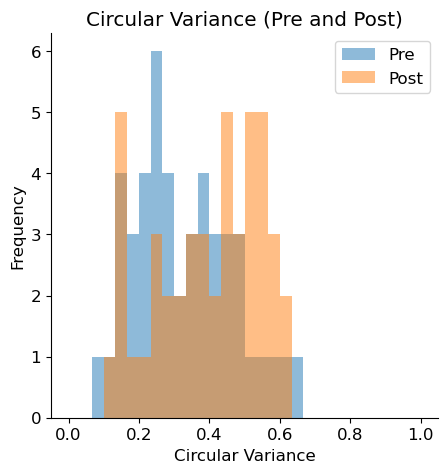

In [117]:
# Plot histogram of circular variance 

fig,ax = plt.subplots(figsize = (5,5))

plt.hist(pre_dirCV, range = (0,1), alpha = 0.5, label = "Pre", bins = 30)
plt.hist(post_dirCV, range = (0,1), alpha = 0.5, label = "Post", bins = 30)

# Add labels and title
plt.xlabel('Circular Variance')
plt.ylabel('Frequency')
plt.title('Circular Variance (Pre and Post)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

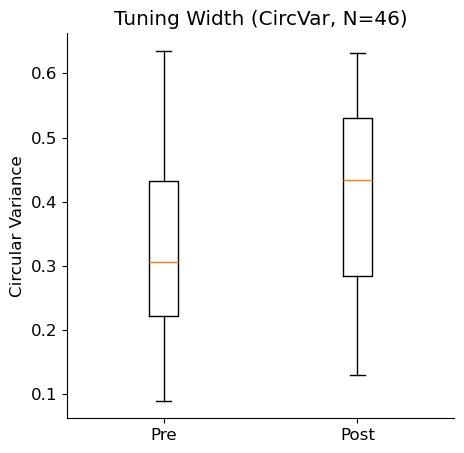

In [118]:
# Creating a box and whisker plot of tuning width
fig,ax = plt.subplots(figsize =(5, 5))

no_nan_i = ~np.isnan(fwhm_vm)
plt.boxplot([pre_dirCV,post_dirCV])
plt.title("Tuning Width (CircVar, N=%i)" %len(pre_CV))
plt.xticks([1,2],["Pre","Post"])
plt.ylabel("Circular Variance")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [110]:
check.shape
delta_fwhm.shape

(46,)

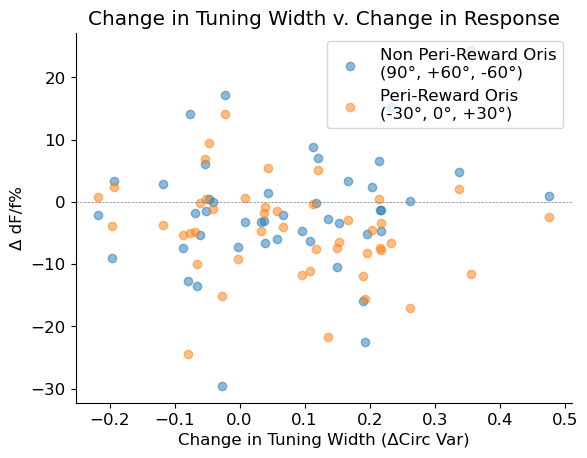

In [121]:
# Combined orientation average against tuning width

# Filtering pre quiet cells out of change data 
no_qc_pre_change = dfoF_V_change_bhStim[~qc_inds_pre,:]
check = np.nanmean(no_qc_pre_change[:,[0,1,5]],axis=1) # inds of nonperireward oris

# Creating a scatter plot of tuning width change and suppression and enhancement
delta_fwhm = np.array(post_dirCV)-np.array(pre_dirCV)

fig, ax = plt.subplots()

# Plotiting the non-perireward oris
plt.scatter(delta_fwhm,check,alpha = 0.5, label="Non Peri-Reward Oris\n(90°, +60°, -60°)")

# Taking mean of perireward oris 
change_filt = np.nanmean(no_qc_pre_change[:,2:4],axis=1)

# Plotiting the non-perireward oris
plt.scatter(delta_fwhm,change_filt,alpha = 0.5,label="Peri-Reward Oris\n(-30°, 0°, +30°)")

# Formatting 
#plt.text(180,14,"N=%i" % len(delta_fwhm))
plt.xlabel("Change in Tuning Width (ΔCirc Var)")
plt.ylabel("Δ dF/f%")
plt.title("Change in Tuning Width v. Change in Response")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axhline(0,color="grey",linestyle="--",linewidth=0.5)
plt.legend()


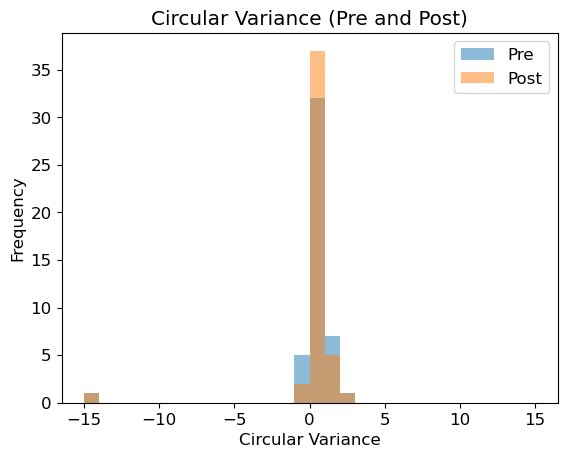

In [60]:
# Plot histogram of circular variance 

plt.hist(cv[0], range = (-15,15), alpha = 0.5, label = "Pre", bins = 30)
plt.hist(cv[1], range = (-15,15), alpha = 0.5, label = "Post", bins = 30)

# Add labels and title
plt.xlabel('Circular Variance')
plt.ylabel('Frequency')
plt.title('Circular Variance (Pre and Post)')

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

NameError: name 'cv' is not defined

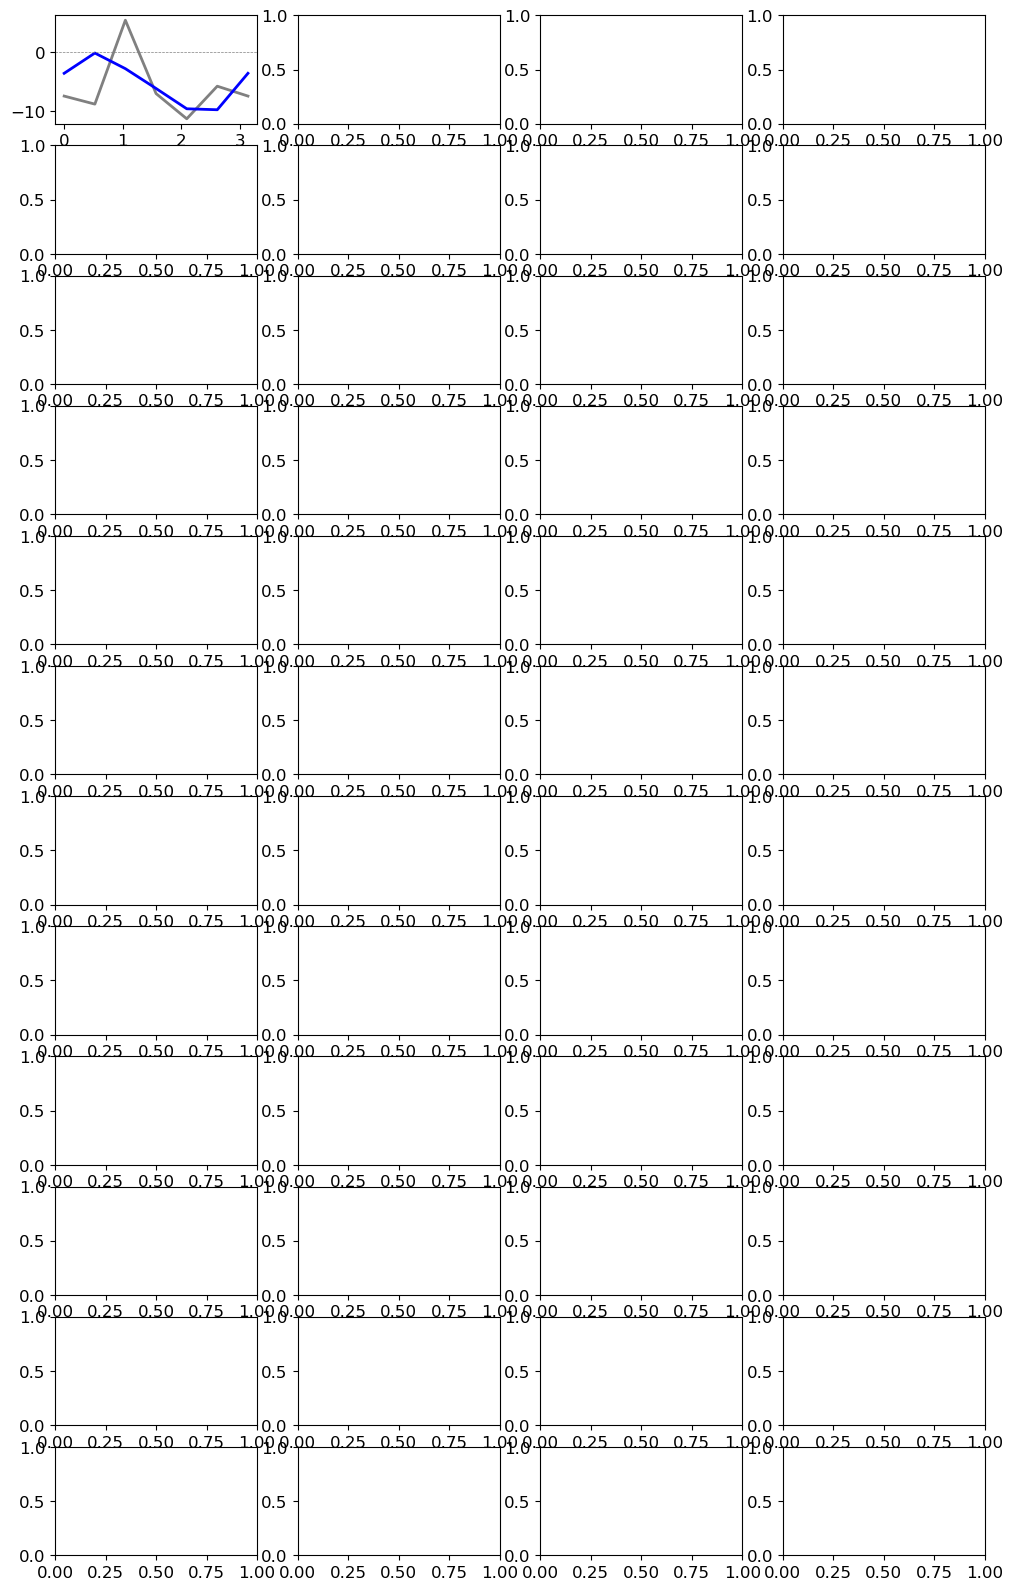

In [20]:
# Plotting all the pre- and post-tuning of each cell# Set the dimensions of the subplot grid
cols = 4
rows = int(np.ceil(len(bhStim_pre[~qc_inds_pre,:])/cols))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 20))
xs = [0,np.pi*0.167,np.pi*0.333,np.pi*0.5,np.pi*0.667,np.pi*0.833,np.pi]

pre_color = 'gray'
post_color = 'blue'


axes = axes.flatten()
pre = bhStim_pre[~qc_inds_pre,:]
post = bhStim_post[~qc_inds_pre,:]

# Iterate through each subplot
for i in range(pre.shape[0]):
        
    ax = axes[i]
    ax.plot(xs,pre[i,:],lw=2,color=pre_color,label='pre')
    ax.plot(xs,post[i,:],lw=2,color=post_color,label='post')
    ax.axhline(0, color='gray',lw=0.5,linestyle='--')
    ax.text(xs[3],40,"circvar_pre = %.2f" %cv[0,i]) # 0 ind is pre 1 is post
    ax.text(xs[3],33,"circvar_post = %.2f" %cv[1,i])


    
    # # To account for a cell with higher responses & to add label to first plot  
    # if i == 21:
    #     ax.set_ylim([-100, 100])
    # elif i == 0:
    #     ax.set_ylabel("dF/F %")
    # else:
    #     ax.set_ylim([-10, 40])   
        
    ax.set_title(f'Cell {i + 1}', fontsize=12)
    
    
    # Code to set the ylims based on values with a minimum of 25% 
    if any(pre[i,:] > 25) or any(post[i,:] > 25):
        y_max = np.max(np.concatenate((pre[i,:],post[i,:])))*1.1 # Making max ylim 1.1 
        ax.set_ylim([-10,y_max])
        
    else: 
        ax.set_ylim([-10, 40])   
        
    if i == 0:
        fig.legend(loc='upper left')
        
    # Setting only the first column to have y labels 
    if np.remainder(i,cols) == 0:
        ax.set_ylabel("dF/F %")
    
    # Setting only the last row to have x labels 
    if (rows*cols) - i - 1< cols:
        ax.set_xticks(
            ticks=[0, np.pi*0.5, np.pi],
            labels=["-90\u00b0", "trained\nori", "90\u00b0"])  
    else: 
        ax.set_xticks(
            ticks=[],
            labels=[])

# Removing axes greater than the number of cells 
for ind in range(rows*cols - pre.shape[0]):
    ax = axes[pre.shape[0] + ind]
    ax.axis('off') 
        
plt.tight_layout()
plt.rcParams.update({'font.size': 12}) 
fig.suptitle("Tuning of Trained Cells Pre & Post", fontsize = 20)
fig.subplots_adjust(top=0.95)

plt.show()

### Plot distribution of width parameters pre and post

<ErrorbarContainer object of 3 artists>

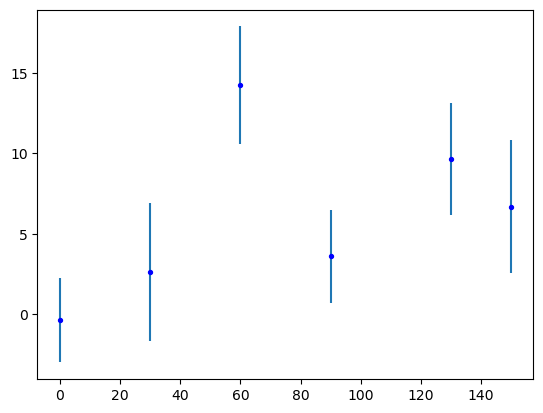

In [18]:
# Checking why error bars are so small
test = pre_data[3,:,:]
err = stats.sem(test,axis=1)
means = test.mean(axis=1)
fig,ax = plt.subplots()
ax.scatter(orientations, means, color='b', zorder=5, s=8, label="ΔF/F Data")
ax.errorbar(orientations, means, yerr=err, linestyle="")

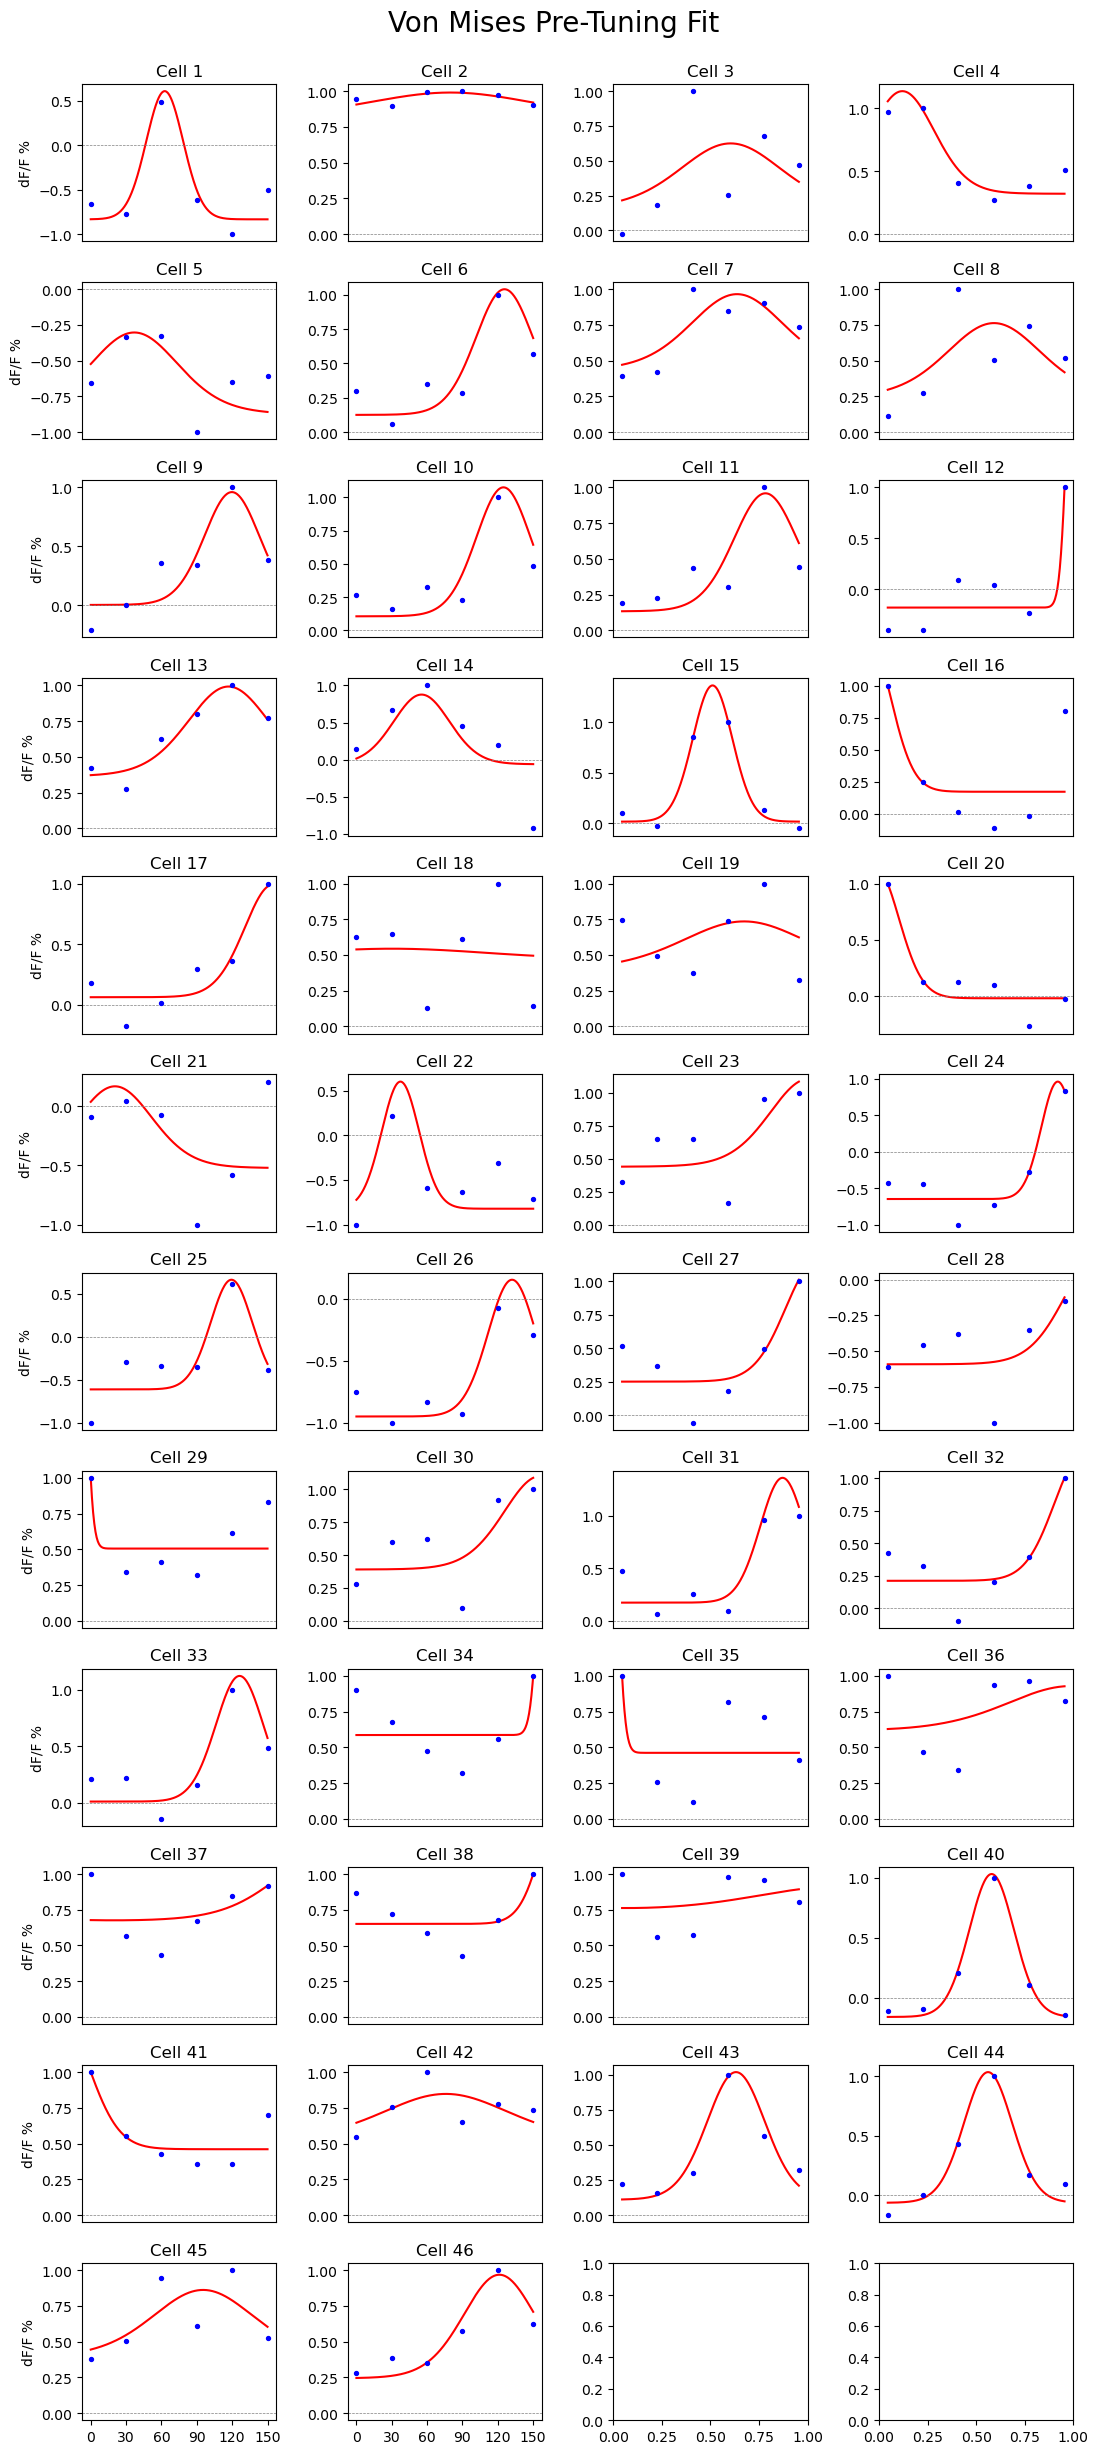

In [53]:
# Plotting the tuning fit for each cell
from scipy.optimize import curve_fit

# Set the dimensions of the subplot grid
cols = 4
rows = int(np.ceil(len(no_qc_vis_pre)/cols))

# Calculating error for cells, doing here cause cell indexes from main variable may change depending on qc def
no_qc_pre_err = stats.sem(pre_data[qc_inds_pre,:,:],axis=2)


# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(11, 25))
axes = axes.flatten() # to make iterable

# Step 1: Input your data
orientations = np.array([0, 30, 60, 90, 120, 150])
orientations_rad = np.deg2rad(orientations)

x_labels = [str(i) for i in orientations]

# Iterate through each subplot
for i in range(no_qc_vis_pre.shape[0]):

    responses = no_qc_vis_pre[i,:]
    
    ax = axes[i]
    ax.plot(theta_fit, fit_response[0,i,:], 'r-', label="Fit") # 0 ind is 1 is post
    ax.scatter(orientations_rad, responses/np.max(np.abs(responses)), color='b', zorder=5, s=8, label="ΔF/F Data")
    # ax.errorbar(orientations_rad, responses/np.max(np.abs(responses)), yerr=no_qc_pre_err[i,:]/np.max(no_qc_pre_err[i,:]), linestyle="")
    ax.axhline(0, color='gray',lw=0.5,linestyle='--')
    #ax.set_ylim([-40, 40])
    ax.set_title(f'Cell {i + 1}', fontsize=12)
    # ax.text(orientations_rad[3],40,"k=%.2f" %kappa_fit[0,i])
    # ax.text(orientations_rad[3],32,"fwhm=%.2f" %fwhm_vm[0,i])

    # ax.set_xticks(
    #     ticks=[0, np.pi*0.5, np.pi],
    #     labels=["-90\u00b0", "trained\nori", "90\u00b0"])
    
    if i == 0:
        ax.set_ylabel('\u0394d F/F%')
        
        
    # # Code to set the ylims based on values with a minimum of 25% 
    # if any(visResp_behavStim_pre[i,:] > 50):
    #     limit = visResp_behavStim_pre[i,:]*1.1 # Making max ylim 1.1 
    #     y_max_ind = np.argmax(abs(limit)) 
        
    #     if limit[y_max_ind] > 0: 
    #         ax.set_ylim([-50,limit[y_max_ind]])
    #     else:
    #         ax.set_ylim([limit[y_max_ind],50])

    # else: 
    #     ax.set_ylim([-50, 50])   
        
    # Setting only the first column to have y labels 
    if np.remainder(i,cols) == 0:
        ax.set_ylabel("dF/F %")
  
    if (rows*cols) - i - 1< cols:
        ax.set_xticks(
            ticks=orientations_rad,
            labels=x_labels)
            #labels=["-90\u00b0", "trained\nori", "90\u00b0"])  
    else: 
        ax.set_xticks(
            ticks=[],
            labels=[])

# Removing axes greater than the number of cells 
for ind in range(rows*cols - visResp_behavStim_pre.shape[0]):
    ax = axes[visResp_behavStim_pre.shape[0] + ind]
    ax.axis('off') 

plt.tight_layout()
plt.rcParams.update({'font.size': 10}) 
fig.suptitle("Von Mises Pre-Tuning Fit", fontsize = 20)
fig.subplots_adjust(top=0.95)

plt.show()


# # --- Plot ---
# plt.figure(figsize=(8, 5))
# plt.plot(theta_fit, fit_response, 'r-', label="Gaussian Fit")
# plt.scatter(orientations, responses, color='b', zorder=5, label="ΔF/F Data")
# plt.xlabel("Orientation (degrees)")
# plt.ylabel("ΔF/F")
# plt.title("Gaussian Fit to Orientation Tuning (Calcium Imaging)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

## Trying to Improve Von-Mises Fit

In [ ]:
def negative_log_likelihood(params, data):
    mu, kappa = params
    return -np.sum(np.log(von_mises_pdf(data, mu, kappa)))

In [ ]:
# inf_check = np.where(np.isinf(fwhm_vm))
# print(len(inf_check))

# fig,ax =  plt.subplots(1,1,figsize = (5,5))

# for i in range(2):

#     data = fwhm_vm[i,no_nan_i[i]]
#     print(data.shape)
#     kde = gaussian_kde(data)
#     x_values = np.linspace(min(data) - 1, max(data) + 1, 300)
#     y_values = kde(x_values)

#     ax.plot(x_values,y_values)
#     ax.set_xlabel("FWHM (deg)")
#     ax.set_ylabel("Density")
#     ax.set_title("Tuning Width (FWHM) Pre and Post")
    
# plt.show()
#     # p.label(, color="")


for i in range(2):
    p=kdeplot(fwhm_vm[i,:])
# from scipy.stats import gaussian_kde

no_nan_i = ~np.isnan(fwhm_vm)


In [25]:
 # Calculate the FWHM for each cell
peak_val = fit_response[0,45,:].max()
peak_ind = np.abs(fit_response[0,45,:] - peak_val).argmin()
half_max = peak_val / 2

# Calculating indices where x-values of data-points would be 
half_ind = np.abs(fit_response[0,45,:] - half_max).argmin()

# Assuming (for now) fits are symmetric so can double HWHM
fwhm_vm[0,45] = np.rad2deg(theta_fit[peak_ind] - theta_fit[half_ind])*2

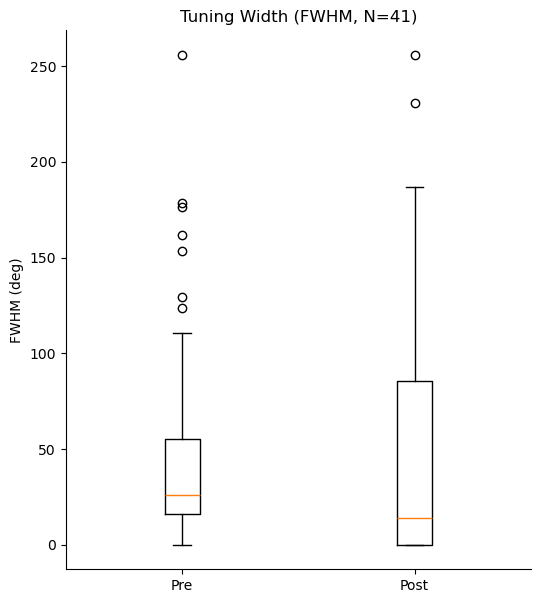

In [14]:
# Creating a box and whisker plot of tuning width
fig,ax = plt.subplots(figsize =(6, 7))

no_nan_i = ~np.isnan(fwhm_vm)
plt.boxplot([fwhm_vm[0,no_nan_i[0]],fwhm_vm[1,no_nan_i[1]]])
plt.title("Tuning Width (FWHM, N=%i)" %len(fwhm_vm[0,no_nan_i[0]]))
plt.xticks([1,2],["Pre","Post"])
plt.ylabel("FWHM (deg)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [67]:

# Filtering pre quiet cells out of change data 
no_qc_pre_change = dfoF_V_change_bhStim[~qc_inds_pre,:]
change_filt = no_qc_pre_change[inds,:]

(22, 6)

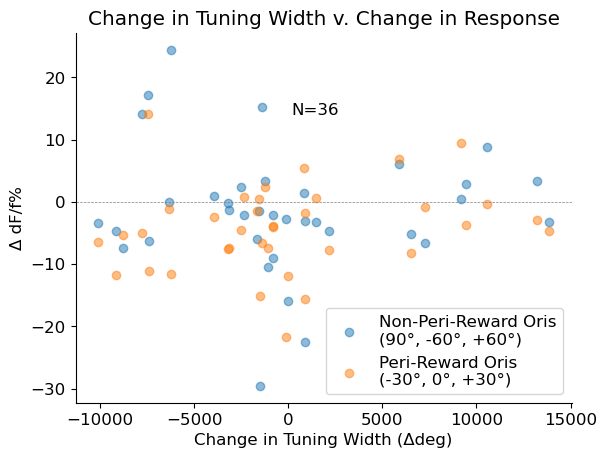

In [122]:
# Combined orientation average against tuning width

# Finding cells that are fit in both cases
inds = np.logical_and(no_nan_i[0],no_nan_i[1])

# Filtering pre quiet cells out of change data 
no_qc_pre_change = dfoF_V_change_bhStim[~qc_inds_pre,:]
check = np.nanmean(no_qc_pre_change[:,[0,1,5]],axis=1) # inds of nonperireward oris

# Creating a scatter plot of tuning width change and suppression and enhancement
delta_fwhm = fwhm_vm[1,inds] - fwhm_vm[0,inds]

fig, ax = plt.subplots()

# Plotiting the non-perireward oris
plt.scatter(delta_fwhm,check[inds],alpha = 0.5, label="Non-Peri-Reward Oris\n(90°, -60°, +60°)")

# Taking mean of perireward oris 
change_filt = np.nanmean(no_qc_pre_change[inds,2:4],axis=1)

# Plotiting the non-perireward oris
plt.scatter(delta_fwhm,change_filt,alpha = 0.5,label="Peri-Reward Oris\n(-30°, 0°, +30°)")

# Formatting 
plt.text(180,14,"N=%i" % len(delta_fwhm))
plt.xlabel("Change in Tuning Width (Δdeg)")
plt.ylabel("Δ dF/f%")
plt.title("Change in Tuning Width v. Change in Response")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axhline(0,color="grey",linestyle="--",linewidth=0.5)
plt.legend()


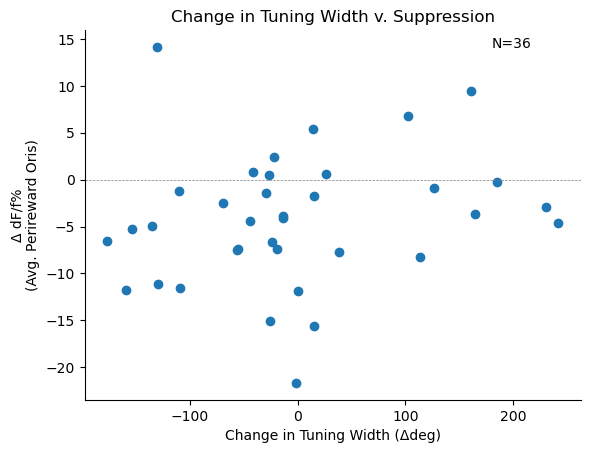

In [16]:
# Finding cells that are fit in both cases
inds = np.logical_and(no_nan_i[0],no_nan_i[1])

# Filtering pre quiet cells out of change data 
no_qc_pre_change = dfoF_V_change_bhStim[~qc_inds_pre,:]
change_filt = np.nanmean(no_qc_pre_change[inds,2:4],axis=1)

# Creating a scatter plot of tuning width change and suppression and enhancement
delta_fwhm = fwhm_vm[1,inds] - fwhm_vm[0,inds]

fig, ax = plt.subplots()

plt.scatter(delta_fwhm,change_filt)
plt.text(180,14,"N=%i" % len(delta_fwhm))
plt.xlabel("Change in Tuning Width (Δdeg)")
plt.ylabel("Δ dF/f%\n(Avg. Perireward Oris)")
plt.title("Change in Tuning Width v. Suppression")
plt.axhline(0,color="grey",linestyle="--",linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.plot(

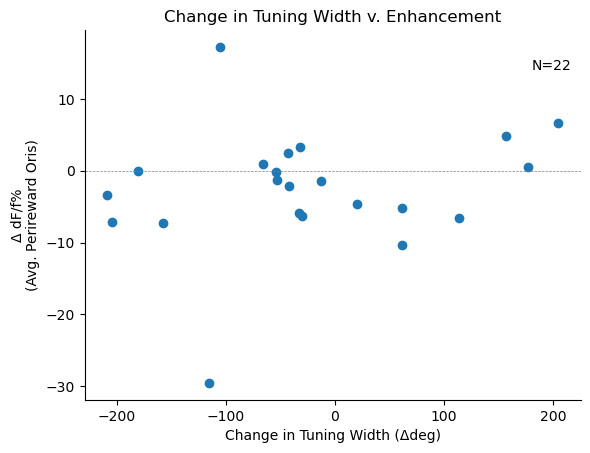

In [109]:
# Finding cells that are fit in both cases
inds = np.logical_and(no_nan_i[0],no_nan_i[1])

# Filtering pre quiet cells out of change data 
no_qc_pre_change = dfoF_V_change_bhStim[~qc_inds_pre,:]
check = np.nanmean(no_qc_pre_change[:,[0,1,5]],axis=1)
# Creating a scatter plot of tuning width change and suppression and enhancement
delta_fwhm = fwhm_vm[1,inds] - fwhm_vm[0,inds]

fig, ax = plt.subplots()

plt.scatter(delta_fwhm,check[inds])

plt.text(180,14,"N=%i" % len(delta_fwhm))
plt.xlabel("Change in Tuning Width (Δdeg)")
plt.ylabel("Δ dF/f%\n(Avg. Perireward Oris)")
plt.title("Change in Tuning Width v. Enhancement")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.axhline(0,color="grey",linestyle="--",linewidth=0.5)

# plt.plot(

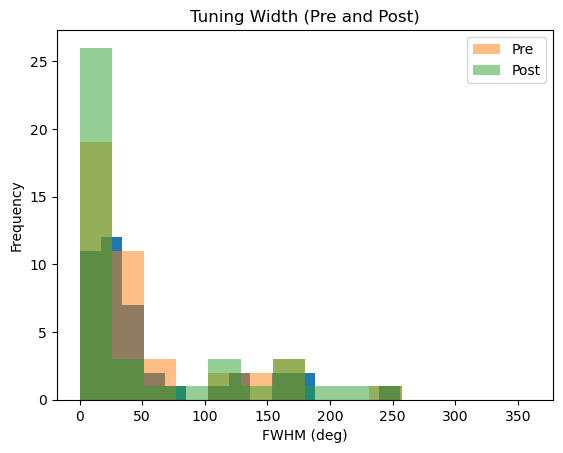

In [19]:
h_pre = plt.hist(fwhm_vm[0,no_nan_i[0]],bins=15)
plt.hist(fwhm_vm[0,no_nan_i[0]], range = (0,360), alpha = 0.5, label = "Pre", bins = 14)
plt.hist(fwhm_vm[1,no_nan_i[1]], range = (0,360), alpha = 0.5, label = "Post", bins = 14)

# Add labels and title
plt.xlabel('FWHM (deg)')
plt.ylabel('Frequency')
plt.title('Tuning Width (Pre and Post)')

# Add legend
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [129]:
low = [i > -0.2 for i in kappa_fit[0,:]]
high = [i < 0.2 for i in kappa_fit[0,:]]

mid = np.logical_and(low,high)
test = np.nanmean(kappa_fit[0,mid])
print(test)
np.where(np.logical_and(mid,no_nan_i[0]))
# 

# Why is kappa so negative 

-0.0010219080648732031


(array([ 6, 16, 20, 23, 25, 35, 38, 40], dtype=int64),)

C:\Users\Connor\AppData\Local\Temp\ipykernel_15796\1391754400.py:1: RuntimeWarning: invalid value encountered in sqrt
  kappa_width = 1/np.sqrt(kappa_fit)


Text(0, 0.5, 'Count')

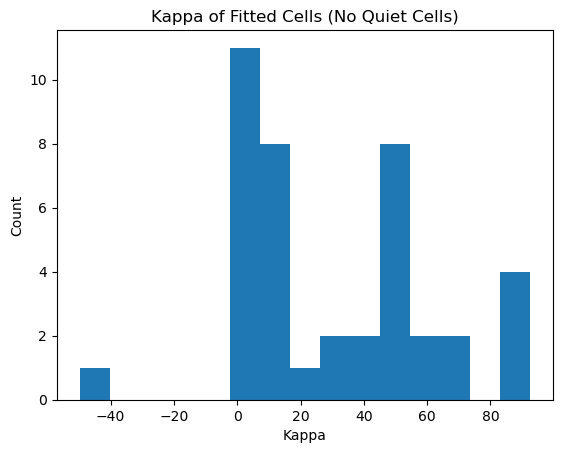

In [20]:
kappa_width = 1/np.sqrt(kappa_fit)
plt.hist(kappa_fit[0,no_nan_i[0]],bins=15)
plt.title("Kappa of Fitted Cells (No Quiet Cells)")
plt.xlabel("Kappa")
plt.ylabel("Count")

## Other test code

In [30]:
import scipy.special as special
import scipy.optimize as opt

# fit von mises pdf, returns parameters and their variances
def fit_vmCustom(xdata,ydata):
    # bounds for parameter search
    bounds = ([-np.pi,0,0,-np.inf],[np.pi,np.inf,np.inf,np.inf])
    # If fit doesn't work fill w NaN
    try:
        paramFits = opt.curve_fit(vmCustom,xdata,ydata,bounds=bounds,max_nfev=1000)
    except:
        paramFits = (np.full(4, np.nan), np.full((4,4), np.nan))
    return paramFits[0]

# von mises pdf, plus scale parameter
def vmCustom(x,mu,kappa,scale,intercept):
    numerator = np.exp(kappa*np.cos(x-mu))
    denom = np.pi*special.iv(0,kappa) # removed multiple 2 in front of pi 
    
    return ((numerator/denom)*scale)+intercept

In [31]:
theta = np.linspace(0, np.pi*5/6, 6)*2 #0 to 150 degrees #theta = np.linspace(0, np.pi*5/6, 6)
ydata_resp = visResp_behavStim_pre[6,:]
paramFits = fit_vmCustom(theta,ydata_resp) #paramFits: mu,kappa,scale,intercept
estimatedFit = vmCustom(theta,paramFits[0],paramFits[1],paramFits[2],paramFits[3])

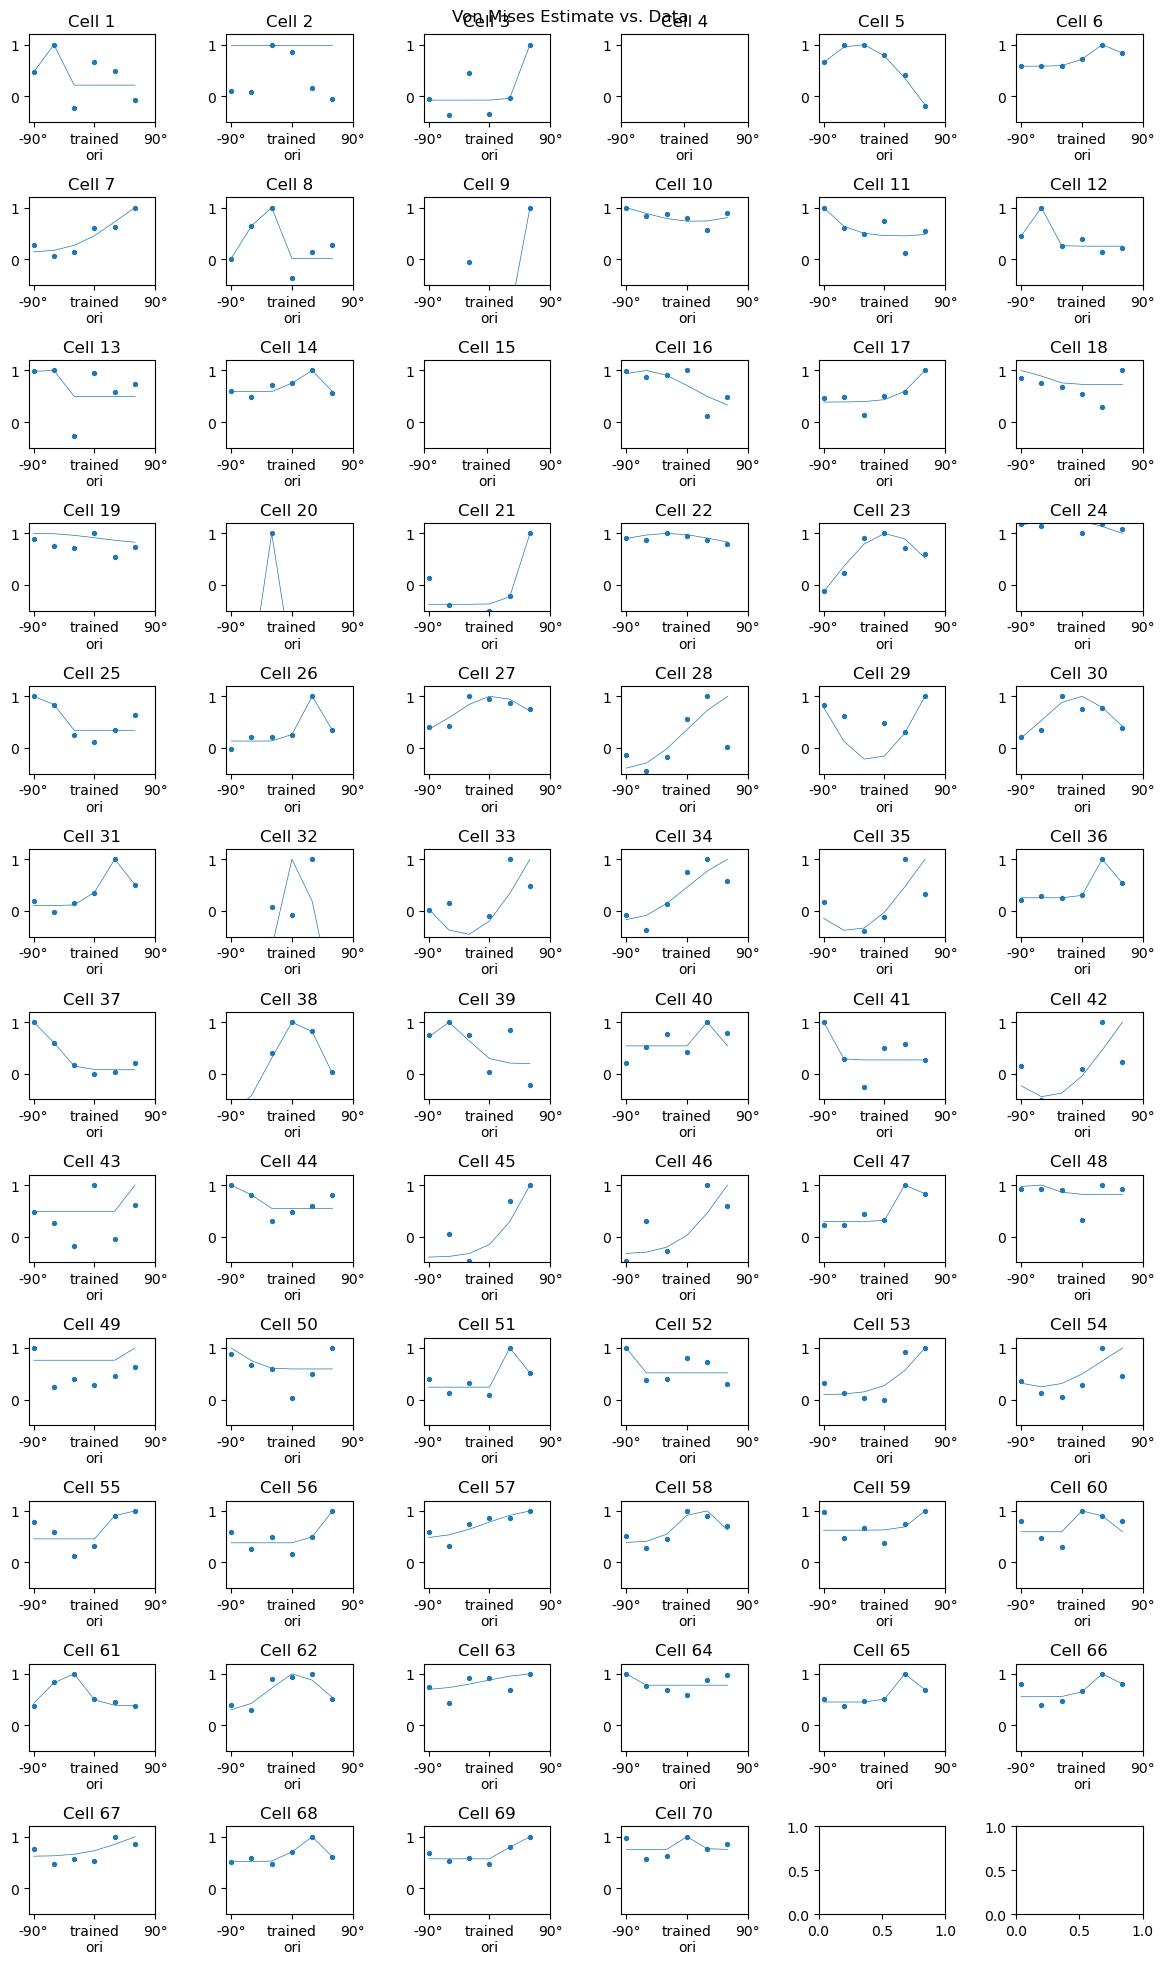

In [178]:
#fig, ax = plt.subplots(1,2,figsize=r_[2,1]*2,sharey=True); font = {'size'   : 10}; mpl.rc('font', **font); ax = ax.ravel()

# Create a figure and a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(12, 20))
ax = axes.flatten() # to make iterable

# Iterate through each subplot
theta = np.linspace(0, np.pi*5/6, 6) #0 to 150 degrees #theta = np.linspace(0, np.pi*5/6, 6)
kappa = []

for iC in range(visResp_behavStim_pre.shape[0]):
    ydata_resp = visResp_behavStim_pre[iC,:]
    #if ydata_resp.max() > 10 and ydata_resp.max() < 14:
    paramFits = fit_vmCustom(theta,ydata_resp) #paramFits: mu,kappa,scale,intercept; paramFits2=alt
    estimatedFit = vmCustom(theta,paramFits[0],paramFits[1],paramFits[2],paramFits[3])
    estimatedFit = estimatedFit/estimatedFit.max()
    rescale = visResp_behavStim_pre[iC,:]/visResp_behavStim_pre[iC,:].max()
    if not np.isnan(estimatedFit).all():
        ax[iC].plot(theta,estimatedFit,lw=0.5)
        ax[iC].scatter(theta,rescale, s=8)
    kappa.append(paramFits[1])
    
    ax[iC].set_title(f'Cell {iC + 1}', fontsize=12)
    ax[iC].set_xticks(
        ticks=[0, np.pi*0.5, np.pi],
        labels=["-90\u00b0", "trained\nori", "90\u00b0"])

    if i == 0:
        ax[iC].set_ylabel('\u0394d F/F%')
        
    ax[iC].set_ylim([-0.5,1.2]);

fig.suptitle("Von Mises Estimate vs. Data");#ax[iC].set_xticks([0,round(np.pi),round(np.pi*2)])
fig.subplots_adjust(top=0.95)
plt.tight_layout()

plt.show()


In [ ]:
import numpy as np
from scipy.special import i0
from scipy.integrate import quad
from scipy.optimize import minimize

# von Mises PDF (unnormalized)
def von_mises_pdf(theta, mu, kappa):
    return np.exp(kappa * np.cos(theta - mu)) / (2 * np.pi * i0(kappa))

# Truncated PDF
def truncated_von_mises_pdf(theta, mu, kappa, a, b):
    normalization, _ = quad(lambda t: von_mises_pdf(t, mu, kappa), a, b)
    return von_mises_pdf(theta, mu, kappa) / normalization

# Negative log-likelihood
def neg_log_likelihood(params, data, a, b):
    mu, kappa = params
    if kappa <= 0:
        return np.inf  # kappa must be positive
    pdf_vals = [truncated_von_mises_pdf(x, mu, kappa, a, b) for x in data]
    return -np.sum(np.log(pdf_vals))

# Example usage
data = np.random.uniform(0, np.pi, size=100)  # Replace with your actual data
a, b = 0, np.pi
initial_guess = [np.pi/2, 1.0]

result = minimize(neg_log_likelihood, initial_guess, args=(data, a, b), bounds=[(0, 2*np.pi), (1e-3, None)])
mu_hat, kappa_hat = result.x

print("Estimated mu:", mu_hat)
print("Estimated kappa:", kappa_hat)

theta_vals = np.linspace(0, np.pi, 300)
pdf_vals = [truncated_von_mises_pdf(theta, mu_hat, kappa_hat, a, b) for theta in theta_vals]

plt.figure(figsize=(8, 5))
plt.hist(data, bins=30, range=(0, np.pi), density=True, alpha=0.5, label="Data histogram")
plt.plot(theta_vals, pdf_vals, 'r-', linewidth=2, label="Fitted truncated von Mises")
plt.title("Fitted Truncated von Mises Distribution")
plt.xlabel("θ (radians)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Average Tuning Plots

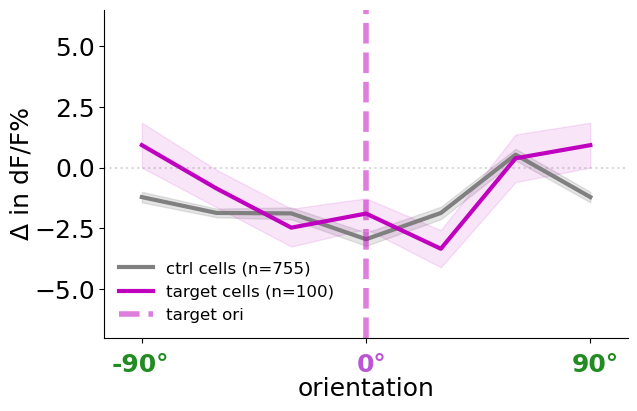

In [55]:
avg_ctrl = np.nanmean(dfoF_V_change_ctrl, axis=0)
avg_ctrl = np.concatenate((avg_ctrl, avg_ctrl[:1]))
avg_bhStim = np.nanmean(dfoF_V_change_bhStim, axis=0)
avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))

sem_ctrl = stats.sem(dfoF_V_change_ctrl, axis=(0),nan_policy='omit')
sem_ctrl = np.concatenate((sem_ctrl, sem_ctrl[:1]))
sem_bhStim = stats.sem(dfoF_V_change_bhStim, axis=(0),nan_policy='omit')
sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))

difs = [avg_ctrl, avg_bhStim]

fig= plt.figure(figsize=(12,8))
#fig.text(0.5, 0.435, '*sub selected visually responsive (df/f>7)\nnot stimd cell pop to match mean vis resp of stimd cells', ha='left', va='center', fontsize=10)
colors = ['grey', 'm']
font = {'size'   : 18}
mpl.rc('font', **font)
#fig.text(0.52, 0.44, 'orientation', ha='center', va='center')
xs = [0,1,2,3,4,5,6]

ax1 = fig.add_subplot(221+1)
ax1.plot(difs[0],color=colors[0],lw=3,label='ctrl cells (n=%i)' %dfoF_V_change_ctrl.shape[0])
ax1.plot(difs[1],color=colors[1],lw=3,label='target cells (n=%i)' %dfoF_V_change_bhStim.shape[0])
ax1.fill_between(xs,difs[0]+sem_ctrl,difs[0]-sem_ctrl,color=colors[0],alpha=0.2)
ax1.fill_between(xs,difs[1]+sem_bhStim,difs[1]-sem_bhStim,color=colors[1],alpha=0.1)
ax1.set_xlabel('orientation')
ax1.set_xticks([0,3,6]); ax1.set_xticklabels([' ',' ',' '])
ax1.text(-0.4,-8.4,'-90°',c='forestgreen',weight='semibold')
ax1.text(2.88,-8.4,'0°',c='mediumorchid',weight='semibold')
ax1.text(5.75,-8.4,'90°',c='forestgreen',weight='semibold')
ax1.set_ylabel('Δ in dF/F%',labelpad= 0)
ax1.set_ylim([-7,6.5])
ax1.set_xlim([-0.5,6.5])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axhline(c='grey',alpha=0.3,ls=':'); ax1.axvline(x=3,c=colors[1],alpha=0.5, ls='--',lw=4, label='target ori')
ax1.legend(loc='lower left',fontsize=12,frameon=False)
plt.subplots_adjust(wspace=None, hspace=None); plt.tight_layout()
#plt.savefig(file_path_save+'changeplot_wsem.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/friedmanng/Desktop/umd_nih/2024commeetee/changeplot_sup.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/phillipscm/Downloads/241021-figs/changeplot_tuncurve.png',bbox_inches='tight',dpi=400)

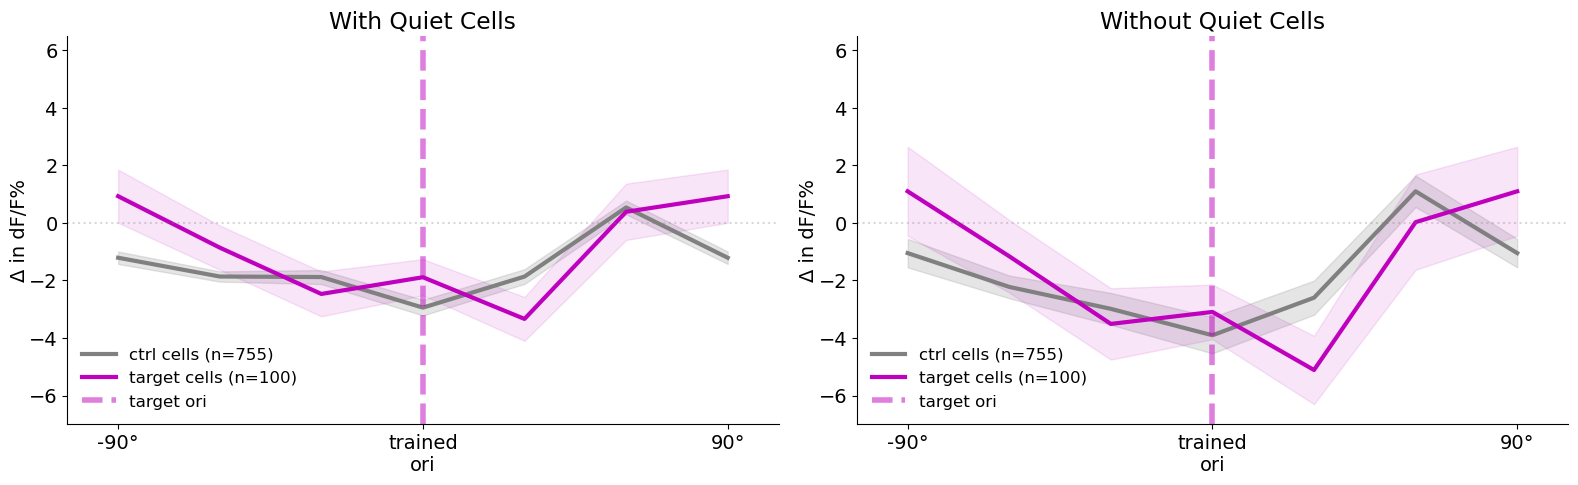

In [52]:
# Creates a plot of main result with and without trained cells that remained quiet, control quiet cells are still included

fig, axes = plt.subplots(1, 2, figsize=(16,5))
data_storage = [dfoF_V_change_ctrl,dfoF_V_change_bhStim]

for i, axis in enumerate(axes): 
    
    if i == 0:
        axis.set_title("With Quiet Cells")
        
        avg_bhStim = np.nanmean(dfoF_V_change_bhStim, axis=0)
        avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))
        sem_bhStim = stats.sem(dfoF_V_change_bhStim, axis=(0),nan_policy='omit')
        sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))

        avg_ctrl = np.nanmean(dfoF_V_change_ctrl, axis=0)
        avg_ctrl = np.concatenate((avg_ctrl, avg_ctrl[:1]))
        sem_ctrl = stats.sem(dfoF_V_change_ctrl, axis=(0),nan_policy='omit')
        sem_ctrl = np.concatenate((sem_ctrl, sem_ctrl[:1]))

    else:
        axis.set_title("Without Quiet Cells")
        avg_bhStim = np.nanmean(dfoF_V_change_bhStim[~trained_stay_quiet_cells], axis=0)
        avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))
        sem_bhStim = stats.sem(dfoF_V_change_bhStim[~trained_stay_quiet_cells], axis=(0),nan_policy='omit')
        sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))

        avg_ctrl = np.nanmean(dfoF_V_change_ctrl[~ctrl_stay_quiet_cells], axis=0)
        avg_ctrl = np.concatenate((avg_ctrl, avg_ctrl[:1]))
        sem_ctrl = stats.sem(dfoF_V_change_ctrl[~ctrl_stay_quiet_cells], axis=(0),nan_policy='omit')
        sem_ctrl = np.concatenate((sem_ctrl, sem_ctrl[:1]))

    difs = [avg_ctrl, avg_bhStim]

    colors = ['grey', 'm']
    font = {'size'   : 14}
    mpl.rc('font', **font)
    xs = [0,1,2,3,4,5,6]

    axis.plot(difs[0],color=colors[0],lw=3,label='ctrl cells (n=%i)' %dfoF_V_change_ctrl.shape[0])
    axis.plot(difs[1],color=colors[1],lw=3,label='target cells (n=%i)' %dfoF_V_change_bhStim.shape[0])
    axis.fill_between(xs,difs[0]+sem_ctrl,difs[0]-sem_ctrl,color=colors[0],alpha=0.2)
    axis.fill_between(xs,difs[1]+sem_bhStim,difs[1]-sem_bhStim,color=colors[1],alpha=0.1)
    axis.set_xticks(
        ticks=[0, 3, 6],
        labels=["-90\u00b0", "trained\nori", "90\u00b0"])
    axis.set_ylabel('Δ in dF/F%',labelpad= 0)
    axis.set_ylim([-7,6.5])
    axis.set_xlim([-0.5,6.5])
            
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.axhline(c='grey',alpha=0.3,ls=':'); axis.axvline(x=3,c=colors[1],alpha=0.5, ls='--',lw=4, label='target ori')
    axis.legend(loc='lower left',fontsize=12,frameon=False)
    
plt.subplots_adjust(wspace=None, hspace=None); plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

#plt.savefig(file_path_save+'changeplot_wsem.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/friedmanng/Desktop/umd_nih/2024commeetee/changeplot_sup.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/phillipscm/Downloads/241021-figs/changeplot_tuncurve.png',bbox_inches='tight',dpi=400)

In [51]:
no_quiet = visResp_behavStim_pre[~trained_stay_quiet_cells,:]
check = any([any(no_quiet[row,:] < 0) for row in range(no_quiet.shape[0])])
print( "Does the pre visual response have negative values?: %s" % check) 

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [12]:
# Calculating the change in dF/F as a percentage of the pre-value 
relative_dfof = np.divide(dfoF_V_change_bhStim[~trained_stay_quiet_cells],abs(visResp_behavStim_pre[~trained_stay_quiet_cells,:]))*100 
relative_dfof_ctrl = np.divide(dfoF_V_change_ctrl[~ctrl_stay_quiet_cells],abs(ctrl_vis_pre[~ctrl_stay_quiet_cells]))*100 

# Statistical analysis 
mwu = stats.mannwhitneyu(relative_dfof,relative_dfof_ctrl, nan_policy='omit')
#w = stats.wilcoxon(relative_dfof,relative_dfof_ctrl)

# Make asterisks 
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

asterisks = [convert_pvalue_to_asterisks(x) for x in mwu.pvalue]
asterisks = np.concatenate((asterisks,asterisks[:1])) # for plotting 
mwu

MannwhitneyuResult(statistic=array([5093., 5235., 5111., 3733., 4148., 5135.]), pvalue=array([0.73219306, 0.50735568, 0.70181741, 0.00638137, 0.07343671,
       0.66205351]))

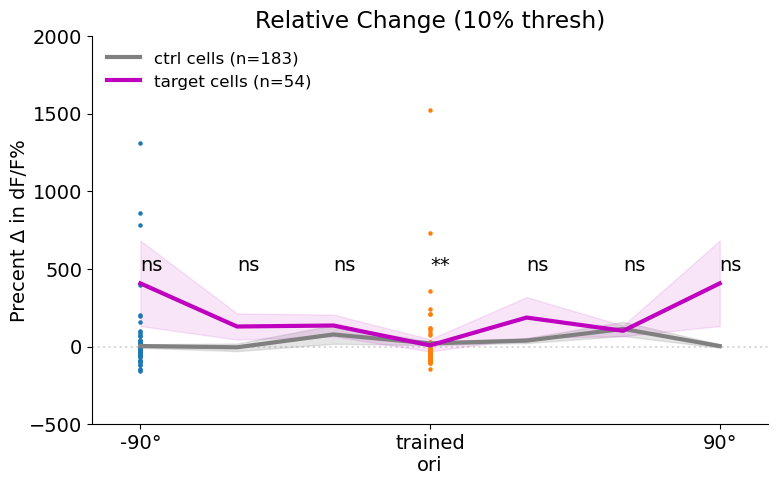

In [13]:
# Plotting Comparing Average Response of Cells with Relative (percent change) to Absolute Change
fig, axis = plt.subplots(1, 1, figsize=(8,5))

avg_ctrl = np.nanmean(relative_dfof_ctrl, axis=0)
avg_ctrl = np.concatenate((avg_ctrl, avg_ctrl[:1]))
sem_ctrl = stats.sem(relative_dfof_ctrl, axis=(0),nan_policy='omit')
sem_ctrl = np.concatenate((sem_ctrl, sem_ctrl[:1]))

avg_bhStim = np.nanmean(relative_dfof, axis=0)
avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))
sem_bhStim = stats.sem(relative_dfof, axis=(0),nan_policy='omit')
sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))

axis.set_title("Relative Change (%i%% thresh)" % quiet_cell_threshold)

difs = [avg_ctrl, avg_bhStim]

colors = ['grey', 'm']
font = {'size'   : 14}
mpl.rc('font', **font)
xs = [0,1,2,3,4,5,6]

axis.plot(difs[0],color=colors[0],lw=3,label='ctrl cells (n=%i)' %relative_dfof_ctrl.shape[0])
axis.plot(difs[1],color=colors[1],lw=3,label='target cells (n=%i)' %relative_dfof.shape[0])
axis.fill_between(xs,difs[0]+sem_ctrl,difs[0]-sem_ctrl,color=colors[0],alpha=0.2)
axis.fill_between(xs,difs[1]+sem_bhStim,difs[1]-sem_bhStim,color=colors[1],alpha=0.1)
axis.set_xticks(
    ticks=[0, 3, 6],
    labels=["-90\u00b0", "trained\nori", "90\u00b0"])
axis.set_ylabel('Precent Δ in dF/F%',labelpad= 0)
axis.set_xlim([-0.5,6.5])
axis.set_ylim([-500,2000])

# Plotting statistical significance
data = np.concatenate((avg_bhStim, avg_ctrl)).flatten() # flattening plotted data to find max 
y_position = data.max() * 1.2 # creating location for asterisks
for idx, pval in enumerate(asterisks):
    plt.text(x=idx, y=y_position, s=pval)

# Plot scatter of y-vlaues on -90 deg 
x_scatter = [0] * relative_dfof[:,0].shape[0]
x_scatter_ = [3] * relative_dfof[:,0].shape[0]

axis.scatter(x_scatter,relative_dfof[:,0],s=5)
axis.scatter(x_scatter_,relative_dfof[:,3], s=5)

axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
axis.axhline(c='grey',alpha=0.3,ls=':'); 
#axis.axvline(x=3,c=colors[1],alpha=0.5, ls='--',lw=4, label='target ori')
axis.legend(loc='upper left',fontsize=12,frameon=False)
    
plt.subplots_adjust(wspace=None, hspace=None); plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

#plt.savefig(file_path_save+'changeplot_wsem.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/friedmanng/Desktop/umd_nih/2024commeetee/changeplot_sup.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/phillipscm/Downloads/241021-figs/changeplot_tuncurve.png',bbox_inches='tight',dpi=400)

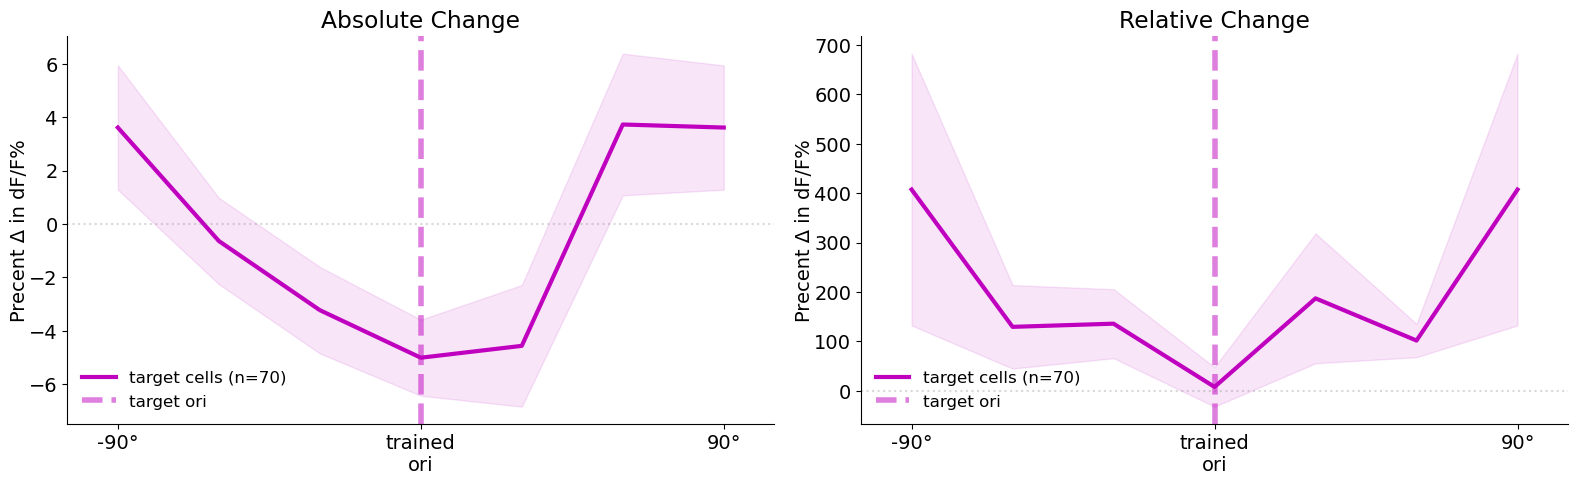

In [14]:
# Plotting Comparing Average Response of Cells with Relative (percent change) to Absolute Change

# Calculating the change in dF/F as a percentage of the pre-value 
relative_dfof = np.divide(dfoF_V_change_bhStim[~trained_stay_quiet_cells],abs(visResp_behavStim_pre[~trained_stay_quiet_cells,:]))*100 

fig, axes = plt.subplots(1, 2, figsize=(16,5))
data_storage = [dfoF_V_change_ctrl,dfoF_V_change_bhStim]

for i, axis in enumerate(axes): 

    if i == 0:
        avg_ctrl = np.nanmean(dfoF_V_change_ctrl, axis=0)
        avg_ctrl = np.concatenate((avg_ctrl, avg_ctrl[:1]))
        sem_ctrl = stats.sem(dfoF_V_change_ctrl, axis=(0),nan_policy='omit')
        sem_ctrl = np.concatenate((sem_ctrl, sem_ctrl[:1]))
    
        avg_bhStim = np.nanmean(dfoF_V_change_bhStim[~trained_stay_quiet_cells], axis=0)
        avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))
        sem_bhStim = stats.sem(dfoF_V_change_bhStim[~trained_stay_quiet_cells], axis=(0),nan_policy='omit')
        sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))
        
        axis.set_title("Absolute Change")

    else:
        avg_bhStim = np.nanmean(relative_dfof, axis=0)
        avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))
        sem_bhStim = stats.sem(relative_dfof, axis=(0),nan_policy='omit')
        sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))
        
        axis.set_title("Relative Change")

    difs = [avg_ctrl, avg_bhStim]

    colors = ['grey', 'm']
    font = {'size'   : 14}
    mpl.rc('font', **font)
    xs = [0,1,2,3,4,5,6]

  #  axis.plot(difs[0],color=colors[0],lw=3,label='ctrl cells (n=%i)' %dfoF_V_change_ctrl.shape[0])
    axis.plot(difs[1],color=colors[1],lw=3,label='target cells (n=%i)' %dfoF_V_change_bhStim.shape[0])
#    axis.fill_between(xs,difs[0]+sem_ctrl,difs[0]-sem_ctrl,color=colors[0],alpha=0.2)
    axis.fill_between(xs,difs[1]+sem_bhStim,difs[1]-sem_bhStim,color=colors[1],alpha=0.1)
    axis.set_xticks(
        ticks=[0, 3, 6],
        labels=["-90\u00b0", "trained\nori", "90\u00b0"])
    axis.set_ylabel('Precent Δ in dF/F%',labelpad= 0)
#    axis.set_ylim([-7,6.5])
    axis.set_xlim([-0.5,6.5])
            
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.axhline(c='grey',alpha=0.3,ls=':'); axis.axvline(x=3,c=colors[1],alpha=0.5, ls='--',lw=4, label='target ori')
    axis.legend(loc='lower left',fontsize=12,frameon=False)
    
plt.subplots_adjust(wspace=None, hspace=None); plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

#plt.savefig(file_path_save+'changeplot_wsem.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/friedmanng/Desktop/umd_nih/2024commeetee/changeplot_sup.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/phillipscm/Downloads/241021-figs/changeplot_tuncurve.png',bbox_inches='tight',dpi=400)

In [15]:
# Finding the orientation with the highest response for each cell (preferred tuning)
maxes = np.max(visResp_behavStim_pre,axis=1)
max_locs = np.argmax(visResp_behavStim_pre,axis=1)

# Pulling the cell index of the maximum value for each orientation (associates cells with their preferred ori)
preferred_ori_inds = [np.where(max_locs == ori_dir) for ori_dir in range(6)]

# Pulling the maximum values in the same way
max_cells = [maxes[preferred_ori_inds[ori_dir]] for ori_dir in range(6)]

# Create a dictionary for easy query
oris = [0, 30, 60, 90, 120, 150]
ori_dict = dict(zip(oris,preferred_ori_inds))
ori_dict

{0: (array([ 3,  9, 10, 24, 36, 40, 43, 48, 51, 63]),),
 30: (array([ 0, 11, 12, 14, 38]),),
 60: (array([ 1,  4,  7, 19, 21, 26, 29, 60]),),
 90: (array([15, 18, 22, 23, 37, 42, 57, 59, 69]),),
 120: (array([ 5, 13, 25, 27, 30, 31, 32, 33, 34, 35, 39, 41, 45, 46, 47, 50, 53,
         61, 64, 65, 66, 67]),),
 150: (array([ 2,  6,  8, 16, 17, 20, 28, 44, 49, 52, 54, 55, 56, 58, 62, 68]),)}

In [16]:
# Hand calculated index change arrays for each ori, this is the change in index locations for orientation
# a janky way to do this plot but...
index_shift_array = [[3,4,5,0,1,2],[2,3,4,5,0,1],[1,2,3,4,5,0],[0,1,2,3,4,5],[5,0,1,2,3,4],[4,5,0,1,2,3]]
#index_shift_array = [[3,3,3,-3,-3,-3],[2,2,2,2,-4,-4],[1,1,1,1,1,-5],[0,0,0,0,0,0],[5,-1,-1,-1,-1,-1],[4,4,-2,-2,-2,-2]]

shift_dict = dict(zip(oris,index_shift_array))

In [17]:
# Aligns data based on preferred orientation preference 
start_inds = [0, 1, 2, 3, 4, 5]
datas = [dfoF_V_change_bhStim,dfoF_V_change_ctrl]
stim_ori_aligned = np.zeros(dfoF_V_change_bhStim.shape)
ctrl_ori_aligned = np.zeros(dfoF_V_change_ctrl.shape)

for dataset in datas: 
    row_num = 0 

    # Loop over each orientation
    for ori, ori_org_cell_inds in ori_dict.items():

        # Create a list of indices to shift values such that the preferred orientation is in the 3 index
        # Uses above hand-coded arrays, the purpose of this is to plot relative to a cells preferred tuning
        reorder = shift_dict[ori]

        # Pulls data from each cell of a given orientation
        # Need [0] to pull array out of tuple
        for cell_ind in ori_org_cell_inds[0]:
            data = dataset[cell_ind,:]

            # Reorder data from each cell such that the preferred orientation is in index 3
            holder = [0] * len(data) 
            for ind in range(len(data)):
                holder[reorder[ind]] = data[ind]

            # Store data in new matrix
            if dataset.shape == dfoF_V_change_bhStim.shape:
                stim_ori_aligned[row_num,:] = holder
            else:
                ctrl_ori_aligned[row_num,:] = holder

            row_num = row_num + 1
            

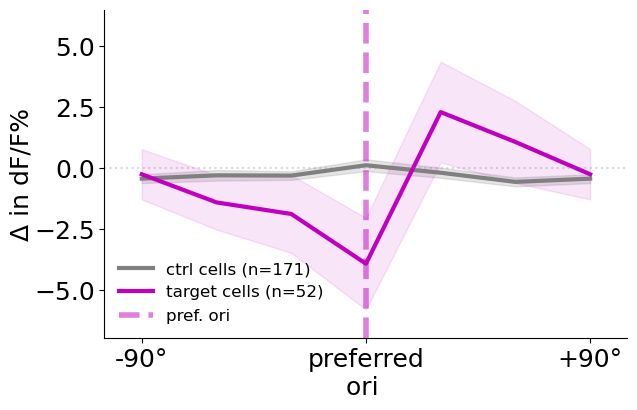

In [18]:
avg_ctrl = np.nanmean(ctrl_ori_aligned, axis=0)
avg_ctrl = np.concatenate((avg_ctrl, avg_ctrl[:1]))
avg_bhStim = np.nanmean(stim_ori_aligned, axis=0)
avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))

sem_ctrl = stats.sem(ctrl_ori_aligned, axis=(0),nan_policy='omit')
sem_ctrl = np.concatenate((sem_ctrl, sem_ctrl[:1]))
sem_bhStim = stats.sem(stim_ori_aligned, axis=(0),nan_policy='omit')
sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))

difs = [avg_ctrl, avg_bhStim]

fig= plt.figure(figsize=(12,8))
#fig.text(0.5, 0.435, '*sub selected visually responsive (df/f>7)\nnot stimd cell pop to match mean vis resp of stimd cells', ha='left', va='center', fontsize=10)
colors = ['grey', 'm']
font = {'size'   : 18}
mpl.rc('font', **font)
#fig.text(0.52, 0.44, 'orientation', ha='center', va='center')
xs = [0,1,2,3,4,5,6]

ax1 = fig.add_subplot(221)
ax1.plot(difs[0],color=colors[0],lw=3,label='ctrl cells (n=171)')
ax1.plot(difs[1],color=colors[1],lw=3,label='target cells (n=52)')
ax1.fill_between(xs,difs[0]+sem_ctrl,difs[0]-sem_ctrl,color=colors[0],alpha=0.2)
ax1.fill_between(xs,difs[1]+sem_bhStim,difs[1]-sem_bhStim,color=colors[1],alpha=0.1)
#ax1.set_xlabel('orientation')
ax1.set_xticks([0,3,6]); ax1.set_xticklabels(['-90°','preferred\nori ','+90°'])
ax1.set_ylabel('Δ in dF/F%',labelpad= 0)
ax1.set_ylim([-7,6.5])
ax1.set_xlim([-0.5,6.5])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axhline(c='grey',alpha=0.3,ls=':'); ax1.axvline(x=3,c=colors[1],alpha=0.5, ls='--',lw=4, label='pref. ori')
ax1.legend(loc='lower left',fontsize=12,frameon=False)
plt.subplots_adjust(wspace=None, hspace=None); plt.tight_layout()
#plt.savefig(file_path_save+'changeplot_wsem.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/friedmanng/Desktop/umd_nih/2024commeetee/changeplot_sup.png',bbox_inches='tight',dpi=400)
plt.savefig('/Users/phillipscm/Downloads/241021-figs/changeplot_tuncurve.png',bbox_inches='tight',dpi=400)

/var/folders/jz/44sr7v096p1d9w_7_z1267br0000gs/T/ipykernel_97153/2466663042.py:27: RuntimeWarning: divide by zero encountered in divide
  baseline_trial_activity_dfof = np.divide(baseline_trial_activity,baseline)
/var/folders/jz/44sr7v096p1d9w_7_z1267br0000gs/T/ipykernel_97153/2466663042.py:27: RuntimeWarning: invalid value encountered in divide
  baseline_trial_activity_dfof = np.divide(baseline_trial_activity,baseline)


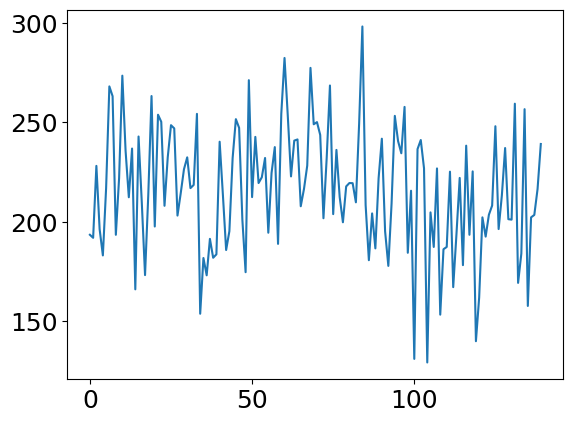

In [19]:
# Pulling variable for trial data 
# (349, 16, 30, 140) = cell x stim (opto and vis) x rep x frame 

# Missing i5398 because less opto patterns used so can't concatenate easily 
trial_ftrace_pre_lseg = np.concatenate((pre_arrs_i5273['trial_ftrace_pre_lseg'],pre_arrs_i5214['trial_ftrace_pre_lseg'],pre_arrs_i5309['trial_ftrace_pre_lseg']))
trial_ftrace_post_lseg = np.concatenate((post_arrs_i5273['trial_ftrace_post_lseg'],post_arrs_i5214['trial_ftrace_post_lseg'],post_arrs_i5309['trial_ftrace_post_lseg']))

pre_arrs_i5398['trial_ftrace_pre_lseg'][:,6:11,:,:]
post_arrs_i5398['trial_ftrace_post_lseg'][:,6:11,:,:]

# Taking only vis traces & concat i5398 
vis_trace_pre = np.concatenate((trial_ftrace_pre_lseg[:,11:16,:,:],pre_arrs_i5398['trial_ftrace_pre_lseg'][:,6:11,:,:]),axis=0)
vis_trace_post = np.concatenate((trial_ftrace_post_lseg[:,11:16,:,:],post_arrs_i5398['trial_ftrace_post_lseg'][:,6:11,:,:]),axis=0)

datas = [vis_trace_pre,vis_trace_post]


plt.plot(post_arrs_i5273['trial_ftrace_post_lseg'][0,1,0,:])

exp_params = pickle.load(open(os.path.join('/Users/phillipscm/data-local/i5398/suite2p/', 'expt_params.pkl'),'rb')); #print('\npre_params)
bline = exp_params['baseline_frame_range']
# Take each cell, section the stims we need, normalize each rep, average 
for data in datas:
    # Normalize baseline data with first half 
    baseline = np.mean(data[:,:,:,bline[0]:int(bline[1]/2)],axis=3) # Averaging across baseline normalization
    baseline_trial_activity = np.mean(data[:,:,:,int(bline[1]/2):bline[1]],axis=3) # Averaging across baseline activity used for measure
    baseline_trial_activity_dfof = np.divide(baseline_trial_activity,baseline)
    baseline_activity = np.mean(baseline_trial_activity_dfof,axis=2) # Average across trials 
    
# HOW TO GET CELL IDENTITIES?



In [20]:
# Aligns data based on preferred orientation preference 
start_inds = [0, 1, 2, 3, 4, 5]
datas = [dfoF_V_change_bhStim,dfoF_V_change_ctrl]
stim_ori_aligned = np.zeros(dfoF_V_change_bhStim.shape)
ctrl_ori_aligned = np.zeros(dfoF_V_change_ctrl.shape)

for dataset in datas: 
    row_num = 0 

    # Loop over each orientation
    for ori, ori_org_cell_inds in ori_dict.items():

        # Create a list of indices to shift values such that the preferred orientation is in the 3 index
        # Uses above hand-coded arrays, the purpose of this is to plot relative to a cells preferred tuning
        reorder = shift_dict[ori]

        # Pulls data from each cell of a given orientation
        # Need [0] to pull array out of tuple
        for cell_ind in ori_org_cell_inds[0]:
            data = dataset[cell_ind,:]

            # Reorder data from each cell such that the preferred orientation is in index 3
            holder = [0] * len(data) 
            for ind in range(len(data)):
                holder[reorder[ind]] = data[ind]

            # Store data in new matrix
            if dataset.shape == dfoF_V_change_bhStim.shape:
                stim_ori_aligned[row_num,:] = holder
            else:
                ctrl_ori_aligned[row_num,:] = holder

            row_num = row_num + 1
            

In [21]:
# Sub-selecting preferred orientations from the data
reward_adj_oris = [60, 90, 120]
reward_adj_cells = [ori_dict.get(ori) for ori in reward_adj_oris]
flat_rew_adj_cells = np.concatenate(reward_adj_cells,axis=1)[0] # formatting into one list of indexes 
cells_from_specfic_oris = dfoF_V_change_bhStim[flat_rew_adj_cells,:] # data for queried cells 

In [22]:
# Calculating the number of quiet cells in our data
pre_quiet_cells = [all(np.abs(dfoF_V_avg_array_pre_active[row,:]) < 10) for row in range(dfoF_V_avg_array_pre_active.shape[0])]
post_quiet_cells = [all(np.abs(dfoF_V_avg_array_post_active[row,:]) < 10) for row in range(dfoF_V_avg_array_post_active.shape[0])]
stay_quiet_cells = np.logical_and(pre_quiet_cells,post_quiet_cells)
print("Number of starting quiet cells: %i" % len([i for i, x in enumerate(pre_quiet_cells) if x]))
print("Number of ending quiet cells: %i" % len([i for i, x in enumerate(post_quiet_cells) if x]))
print("Cells that remained quiet: %i" % len([i for i, x in enumerate(stay_quiet_cells) if x]))

NameError: name 'dfoF_V_avg_array_pre_active' is not defined

In [ ]:
## LEFT OFF HERE the code above can be formatted to subselected cells with specific orientation tuning
# in this cell I was planning to subcategorize the cells based on OSI to get narrow and broadly-tuned cells

osi_threshold = 0.5 
test_osi = np.linspace(0,1,len(dfoF_V_change_bhStim)) # Dummy data 

In [ ]:
# NOT COMPLETE: can use this code to compare main effect with cells of different tuning width

fig, axes = plt.subplots(1, 2, figsize=(16,5))
data_storage = [dfoF_V_change_ctrl,dfoF_V_change_bhStim]

for i, axis in enumerate(axes): 
    
    avg_ctrl = np.nanmean(dfoF_V_change_ctrl, axis=0)
    avg_ctrl = np.concatenate((avg_ctrl, avg_ctrl[:1]))
    sem_ctrl = stats.sem(dfoF_V_change_ctrl, axis=(0),nan_policy='omit')
    sem_ctrl = np.concatenate((sem_ctrl, sem_ctrl[:1]))
        
    if i == 0:
        
        avg_bhStim = np.nanmean(dfoF_V_change_bhStim, axis=0)
        avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))
        sem_bhStim = stats.sem(dfoF_V_change_bhStim, axis=(0),nan_policy='omit')
        sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))

    else:

        avg_bhStim = np.nanmean(cells_from_specfic_oris, axis=0)
        avg_bhStim = np.concatenate((avg_bhStim, avg_bhStim[:1]))
        sem_bhStim = stats.sem(cells_from_specfic_oris, axis=(0),nan_policy='omit')
        sem_bhStim = np.concatenate((sem_bhStim, sem_bhStim[:1]))
        
        
    difs = [avg_ctrl, avg_bhStim]

    #fig.text(0.5, 0.435, '*sub selected visually responsive (df/f>7)\nnot stimd cell pop to match mean vis resp of stimd cells', ha='left', va='center', fontsize=10)
    colors = ['grey', 'm']
    font = {'size'   : 14}
    mpl.rc('font', **font)
    #fig.text(0.52, 0.44, 'orientation', ha='center', va='center')
    xs = [0,1,2,3,4,5,6]

    axis.plot(difs[0],color=colors[0],lw=3,label='ctrl cells (n=%i)' %dfoF_V_change_ctrl.shape[0])
    axis.plot(difs[1],color=colors[1],lw=3,label='target cells (n=%i)' %dfoF_V_change_bhStim.shape[0])
    axis.fill_between(xs,difs[0]+sem_ctrl,difs[0]-sem_ctrl,color=colors[0],alpha=0.2)
    axis.fill_between(xs,difs[1]+sem_bhStim,difs[1]-sem_bhStim,color=colors[1],alpha=0.1)
    axis.set_xticks(
        ticks=[0, 3, 6],
        labels=["-90\u00b0", "trained\nori", "90\u00b0"])
    axis.set_ylabel('Δ in dF/F%',labelpad= 0)
    axis.set_ylim([-7,6.5])
    axis.set_xlim([-0.5,6.5])
    
    if i == 0: 
        axis.set_title("With Quiet Cells")
    else:
        axis.set_title("Without Quiet Cells")

            
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.axhline(c='grey',alpha=0.3,ls=':'); axis.axvline(x=3,c=colors[1],alpha=0.5, ls='--',lw=4, label='target ori')
    axis.legend(loc='lower left',fontsize=12,frameon=False)
    
plt.subplots_adjust(wspace=None, hspace=None); plt.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

#plt.savefig(file_path_save+'changeplot_wsem.png',bbox_inches='tight',dpi=400)
#plt.savefig('/Users/friedmanng/Desktop/umd_nih/2024commeetee/changeplot_sup.png',bbox_inches='tight',dpi=400)
plt.savefig('/Users/phillipscm/Downloads/241021-figs/changeplot_tuncurve.png',bbox_inches='tight',dpi=400)